In [1]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
import pywt
from sklearn.preprocessing import MinMaxScaler
from torch import FloatTensor
from scipy.stats import skew, kurtosis, entropy
from math import gcd
from functools import reduce

# Req for package
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, set_seed
from SkinLearning.NN.Models import MultiTemporal


torch.backends.cudnn.benchmark = True

In [2]:
set_seed()

In [3]:
# Folder name will correspond to index of sample
class SkinDataset(Dataset):
    def __init__(
        self,
        scaler,
        signalFolder="D:/SamplingResults2",
        sampleFile="../Data/newSamples.pkl",
        extraction_args={},
        runs=range(65535),
        steps=128,    
    ):
        # Load both disp1 and disp2 from each folder
        # Folders ordered according to index of sample
        # Use the corresponding sample as y -> append probe?
        self.input = []
        self.output = []
        
        with open(f"{sampleFile}", "rb") as f:
             samples = pickle.load(f)
        
        self.min = np.min(samples[runs])
        self.max = np.max(samples[runs])
        
        
        for run in tqdm(runs):
            inp = []
            fail = False
            
            files = os.listdir(f"{signalFolder}/{run}/")
            
            if files != ['Disp1.csv', 'Disp2.csv']:
                continue
            
            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                
                # Skip if unconverged
                if a['x'].max() != 7.0:
                    fail = True
                    break

                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
                    
                
                inp.append(interped.astype("float32"))
            
            if not fail:
                if len(inp) != 2:
                    raise Exception("sdf")

                self.input.append(inp)
                self.output.append(samples[int(run)])
        
        scaler.fit(self.output)
        self.output = scaler.fit_transform(self.output)
        self.output = tensor(self.output).type(FloatTensor)
        
        # Perform WPD on all sets of signals
        # Using the given parameters
        extracted_features = []
        for signals in self.input:
            extraction_args['signals'] = signals
            extracted_features.append(waveletExtraction(**extraction_args))
        self.input = extracted_features
        del extracted_features
            
        self.input = tensor(np.array(self.input)).type(FloatTensor)
        
        
    def __len__(self):
        return len(self.output)
    
    def __getitem__(self, idx):
        sample = {"input": self.input[idx], "output": self.output[idx]}
        return sample
    
    

In [4]:
"""
    Creates the data set from filtered samples
    Returns the dataset and the scaler
"""
def getDataset(**kwargs):
    # Get filtered data
    if not 'runs' in kwargs.keys():
        with open("../Data/filtered.pkl", "rb") as f:
            runs = pickle.load(f)

        kwargs['runs'] = runs

    scaler = MinMaxScaler()
    dataset = SkinDataset(scaler=scaler, **kwargs)

    return dataset, scaler

In [5]:
"""
    Creates a train/test split from the given data
    Returns train and test data loaders
"""
def getSplit(dataset, p1=0.8):
    train_n = int(p1 * len(dataset))
    test_n = len(dataset) - train_n
    train_set, test_set = random_split(dataset, [train_n, test_n])

    return DataLoader(train_set, batch_size=32, shuffle=True), \
        DataLoader(test_set, batch_size=32, shuffle=True)

In [6]:
"""
    Performs wavelet decomposition on the given signals
    
    Parameters:
        x (List):
            2D array containing two signals.
        method (string):
            The feature extraction method.
            Options:
                raw: Uses the raw coefficients.
                stats: Uses stats given by the stats parameter.
                energy: calculates the energy from the coefficients.
                entropy: Calculates the entropy from the coefficients.
                min-max: Calculates the minimum and the maximum.
                
"""
def waveletExtraction(
    x,
    method,
    combined=False,
    wavelet='db4',
    level=6,
    combine_method="concatenate",
    order="freq",
    levels=[6]
):
    #s = MinMaxScaler()
    #x = s.fit_transform(x)
    
    # If highly correlated then combining could be useful
    if combined:
        coeffs = pywt.WaveletPacket(x, wavelet=wavelet, maxlevel=level)
        coeffs = extractCoeff(coeffs, level)
        
        
        features = []
        if method == "raw":
                features.append(coeffs)
        else:
            if method == "entropy":
                s1 = MinMaxScaler()
                coeffs = s1.fit_transform(coeffs)
                
            # Get sub-freqency band details
            for i in range(len(coeffs)):  
                    if method == "stats":
                        features.append(stats(coeffs[i]))
                        print(stats(coeffs[i]))
                    elif method == "entropy":
                        features.append(entropy(coeffs[i]))
                    elif method == "min-max":
                        features.append(minMax(coeffs[i]))
                    elif method=="energy":
                        features.append(getEnergy(coeffs[i]))
                    
        return np.array(features).flatten()

    else:
        wp1 = pywt.WaveletPacket(x[0], wavelet=wavelet, maxlevel=level)
        wp2 = pywt.WaveletPacket(x[1], wavelet=wavelet, maxlevel=level)
        
        coeffs1 = extractCoeff(wp1, 0)
        coeffs2 = extractCoeff(wp2, 0)

        features1, features2 = [], []
        
        
        if method == "raw":
                features1, features2 = coeffs1, coeffs2
        else:
            if method == "entropy":
                s1 = MinMaxScaler()
                s2 = MinMaxScaler()
                coeffs1 = s1.fit_transform(coeffs1)
                coeffs2 = s2.fit_transform(coeffs2)
            
            # Get sub-freqency band details
            for i in range(len(coeffs1)):
                if method == "stats":
                    features1.append(stats(coeffs1[i]))
                    features2.append(stats(coeffs2[i]))
                elif method == "entropy":
                    features1.append(entropy(coeffs1[i]))
                    features2.append(entropy(coeffs2[i]))
                elif method == "min-max":
                    features1.append(minMax(coeffs1[i]))
                    features2.append(minMax(coeffs2[i]))
                elif method=="energy":
                    features1.append(getEnergy(coeffs1[i]))
                    features2.append(getEnergy(coeffs2[i]))
        
        if combine_method == "concatenate":
            return [np.array(features1).flatten(), np.array(features2).flatten()]
        else:
            features1 = np.array(features1)
            features2 = np.array(features2)
            
            signal1_coeffs_transposed = features1.T
            signal2_coeffs_transposed = features2.T

            # Flatten the transposed arrays into 1D arrays
            signal1_coeffs_flattened = signal1_coeffs_transposed.flatten()
            signal2_coeffs_flattened = signal2_coeffs_transposed.flatten()

            # Interleave the flattened arrays element-wise
            combined_coeffs = np.empty(signal1_coeffs_flattened.shape[0] + signal2_coeffs_flattened.shape[0], dtype=signal1_coeffs_flattened.dtype)
            combined_coeffs[0::2] = signal1_coeffs_flattened
            combined_coeffs[1::2] = signal2_coeffs_flattened


            return combined_coeffs #np.concatenate(flattened) -> works better?

def minMax(coeffs):
    return [
        np.min(coeffs),
        np.max(coeffs)
    ]
    
def stats(c):

    return [
                np.mean(c),
                np.std(c),
                skew(c),
                kurtosis(c)
            ]

# Find the common denominator of the number of intervals for each level
def reorganise(features):
    # Calculate the number of time intervals for each level
    num_intervals = [len(feature) for feature in features]

    common_denominator = reduce(lambda x, y: x * y // gcd(x, y), num_intervals)

    # Initialize an empty list to store the reorganized features
    reorganized_features = []

    # Iterate through the time intervals and add the corresponding features to the reorganized list
    for t in range(common_denominator):
        interval_features = []

        for level_features, num_intervals_level in zip(features, num_intervals):
            
            # Find the corresponding feature index for the current time interval and level
            index = (t * num_intervals_level) // common_denominator
            interval_features.append(level_features[int(index)])

        reorganized_features.append(interval_features)
    
    return np.array(reorganized_features)

def extractCoeff(wp, level=6, order='freq'):
    coeffs = []
    coeffs =  wp.get_level(level, order)
    features = np.array([c.data for c in coeffs])
    return features

def getEnergy(coefficients):
    energy = np.sum(np.square(coefficients))
    return energy

In [7]:
import numpy as np
import pywt
from scipy.stats import skew, kurtosis
from scipy.special import entr

def waveletExtraction(
    signals,
    method,
    combined=False,
    wavelet='db4',
    level=6,
    combine_method='concatenate',
    order='freq',
    levels=[6],
    stats=['mean', 'std', 'skew', 'kurtosis'],
    normalization=None,
):
    def get_statistics(coefficients, stats_list):
        features = []
        for stat in stats_list:
            if stat == 'mean':
                features.append(np.mean(coefficients))
            elif stat == 'std':
                features.append(np.std(coefficients))
            elif stat == 'skew':
                features.append(skew(coefficients))
            elif stat == 'kurtosis':
                features.append(kurtosis(coefficients))
        return features

    def extract_features_single_signal(signal, method, wavelet, level, order, levels, stats_list):
        wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
        features = []

        for l in levels:
            coeffs =  wp.get_level(level, order)
            coeffs = np.array([c.data for c in coeffs])

            if method == "energy" or method == "min-max":
                 # Normalise
                coeffs = (coeffs - np.mean(coeffs)) / np.std(coeffs)
                
            if method == 'raw':
                features.extend(np.concatenate(coeffs))
            elif method == 'energy':       
                features.extend([np.sum(np.square(c)) for c in coeffs])
            elif method == 'entropy':
                features.extend([np.sum(entr(np.abs(c))) for c in coeffs])
            elif method == 'min-max':
                features.extend([np.min(c) for c in coeffs] + [np.max(c) for c in coeffs])
            elif method == 'stats':
                for c in coeffs:
                    features.extend(get_statistics(c, stats_list))
        
            # Optional normalisation for raw and energy
            if normalization == "indvidual":
                features = (features - min(features)) / (max(features) - min(features))
                
        return features

    if combined:
        combined_signal = np.concatenate(signals, axis=0)
        combined_features = extract_features_single_signal(combined_signal, method, wavelet, level, order, levels, stats)
        features = combined_features
    else:
        features_list = [extract_features_single_signal(signal, method, wavelet, level, order, levels, stats) for signal in signals]

        if combine_method == 'concatenate':
            features = np.concatenate(features_list)
        elif combine_method == 'interleave':
            features = np.ravel(np.column_stack(features_list))
        else:
            raise ValueError("Invalid combine_method. Choose from 'concatenate' or 'interleave'.")
    
    if normalization == "combined":
        features = (features - np.min(features, axis=0)) / (np.max(features, axis=0) - np.min(features, axis=0))
    
    return features


In [2]:
import itertools

def create_datasets(max_level=6):
    def parse_dataset(method, combined, order, key):
        extraction_args = {
            "signals": None,
            "method": method,
            "combined": combined,
            "wavelet": "db4",
            "level": max_level,
            "order": order,
            "levels": [6],
            "normalization": normalize,
            "stats": stats if method == "stats" else None,
        }
        print(stats, stats_key)
        combined_str = 'combined' if combined else 'separated'
        dataset_dict[(combined_str, order)][key] = getDataset(
            extraction_args=extraction_args
        )

    dataset_dict = {
        #("combined", "freq"): {},
        ("separated", "natural"): {},
        #("combined", "natural"): {},
        ("separated", "freq"): {},
    }

    all_stats = [
        ['mean', 'std'],
        ['mean', 'std', 'skew'],
        ['mean', 'std', 'skew', 'kurtosis']
    ]
        
    print(len(all_stats))

    for method in ['stats', 'min-max']:
        for combined in [False]:
            for order in ['freq', 'natural']:  # , "natural"]:
                for normalize in ['None']:
                    for stats in all_stats:
                        if method == "stats":
                            stats_key = ' '.join(stats)
                        else:
                            stats_key = 'None'
                        parse_dataset(method, combined, order, (method, normalize, stats_key))

    return dataset_dict

all_datasets = create_datasets(max_level=6)

3
['mean', 'std'] mean std


NameError: name 'getDataset' is not defined

In [8]:
def create_top_3(max_level=6):
    def parse_dataset(method, combined, order, normalize, stats):
        key = (method, normalize, stats)
        normalize = key[1]
        stats = key[-1]
        extraction_args = {
            "signals": None,
            "method": method,
            "combined": combined,
            "wavelet": "db4",
            "level": max_level,
            "order": order,
            "levels": [6],
            "normalization": normalize,
            "stats": stats if method == "stats" else None,
        }
        print(stats)
        combined_str = 'combined' if combined else 'separated'
        dataset_dict[(combined_str, order)][key] = getDataset(
            extraction_args=extraction_args
        )

    dataset_dict = {
        #("combined", "freq"): {},
        ("separated", "natural"): {},
        #("combined", "natural"): {},
        ("separated", "freq"): {},
    }

    all_stats = [
        ['mean', 'std'],
        ['mean', 'std', 'skew'],
        ['mean', 'std', 'skew', 'kurtosis']
    ]
        
    print(len(all_stats))
    
    # LSTM based on concatenate, with dataset using ('separated', 'natural') ('raw', 'None')
    # 92% MAPE, 0.056 MAE
    parse_dataset(
        "raw",
        False,
        "natural",
        False,
        ("None")
    )
    
    # LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', 'None')
    # 92% MAPE, 0.054 MAE
    parse_dataset(
        "entropy",
        False,
        "natural",
        False,
        ("None")
    )
    
    # LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', 'None')
    # 93% MAPE, 0.049 MAE
    parse_dataset(
        "entropy",
        False,
        "freq",
        False,
        ("None")
    )
    
    return dataset_dict

all_datasets = create_top_3()

3
None


100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 232.35it/s]


None


100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 230.70it/s]


None


100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 244.61it/s]


In [130]:
def create_overfitters(max_level=6):
    def parse_dataset(method, combined, order, normalize, stats):
        key = (method, normalize, stats)
        normalize = key[1]
        stats = key[-1]
        
        extraction_args = {
            "signals": None,
            "method": method,
            "combined": combined,
            "wavelet": "db4",
            "level": max_level,
            "order": order,
            "levels": [6],
            "normalization": normalize,
            "stats": stats if method == "stats" else None,
        }
        
        combined_str = 'combined' if combined else 'separated'
        dataset_dict[(combined_str, order)][key] = getDataset(
            extraction_args=extraction_args,
            #runs=[1,2,3]
        )

    dataset_dict = {
        ("combined", "freq"): {},
        #("separated", "natural"): {},
        #("combined", "natural"): {},
        ("separated", "freq"): {},
    }
    
    # LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew kurtosis')
    # 90.1% MAPE, 0.066 MAE, last loss: 0.02
    parse_dataset(
        'stats',
        False,
        'freq',
        'None',
        ('mean', 'std', 'skew', 'kurtosis')
    )
    
    # LSTM concatenate, with dataset using ('combined', 'freq') ('stats', 'None', 'mean_std_skew')
    # 91.7% MAPE, 0.062 MAE, final training loss: 0.023
    parse_dataset(
        'stats',
        False,
        'freq',
        'None',
        ('mean', 'std', 'skew')
    )
    
    # LSTM concatenate, with dataset using ('combined', 'freq') ('stats', 'None', 'mean_std_skew_kurtosis')
    # 90% MAPE, 0.06 MAE, final training loss: 0.023
    parse_dataset(
        'stats',
        True,
        'freq',
        'None',
        ('mean', 'std', 'skew', 'kurtosis')
    )

    # Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew')
    # 89% MAPE, 0.066 MAE, last loss: 0.02
    parse_dataset(
        'stats',
        False,
        'freq',
        'None,',
        ('mean', 'std', 'skew')
     )
    
    #LSTM based on concatenate, with dataset using ('combined', 'freq') ('min-max', 'None')
    #- 91% MAPE, 0.04 MAE, final training loss: 0.047
    parse_dataset(
        'min-max',
        False,
        'freq',
        'None',
        ('None')
     )

    return dataset_dict

all_datasets = create_overfitters()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 241.24it/s]


In [129]:
print(lengths)

{('combined', 'freq'): {('stats', 'None', ('mean', 'std', 'skew', 'kurtosis')): 256}, ('separated', 'freq'): {('stat', 'None', ('mean', 'std', 'skew', 'kurtosis')): 0, ('stats', 'None', ('mean', 'std', 'skew')): 384, ('stats', 'None,', ('mean', 'std', 'skew')): 384, ('min-max', 'None', 'None'): 256}}


#datasets = {}

for comb in ['non-combined']:
    #datasets[comb] = {}
    
    for method in ['min-max', 'stats', 'raw', 'entropy', 'energy']:
        datasets[comb][method] = getDataset(method=method, combined = True if comb == "combined" else False)

In [113]:
def create_lengths_and_loaders(datasets, split_ratio=0.8, batch_size=32):
    lengths = {}
    loaders = {}

    for comb in datasets.keys():
        loaders[comb] = {}
        lengths[comb] = {}
        # Get train and test split
        
        for method in datasets[comb].keys():
            train_data, test_data = getSplit(datasets[comb][method][0], split_ratio)

            # Create DataLoaders
            train_loader, test_loader = getSplit(datasets[comb][method][0])

            # Update the loaders dictionary
            loaders[comb][method] = {'train': train_loader, 'test': test_loader}

            # Update the lengths dictionary
            lengths[comb][method] = len(datasets[comb][method][0][0]['input'])

    return lengths, loaders
lengths, loaders = create_lengths_and_loaders(all_datasets)

1024
128
128


# Models

In [1]:
class LSTMMulti(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, num_layers=1, method="concatenate", single_fc=False, temporal_type="LSTM"):
        super(LSTMMulti, self).__init__()
        self.method = method
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.temporal_type = temporal_type
        
        if temporal_type == "LSTM":
            net = nn.LSTM
        elif temporal_type == "RNN":
            net = nn.RNN
        else:
            net = nn.GRU

        if method == 'concatenate':
            self.lstm = net(input_size, hidden_size, num_layers, batch_first=True)
        elif method == 'multi_channel':
            self.lstm = net(2, hidden_size, num_layers, batch_first=True)
        elif method == 'independent':
            self.lstm = net(input_size//2, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid method. Choose from 'concatenate', 'multi_channel', or 'independent'.")
        
        if method == 'independent':
            fc_in = hidden_size*2
            self.fc = nn.Linear(hidden_size*2, 6)
        else:
            fc_in = hidden_size
                
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )

    def forward(self, x):
        batch_size = x.size(0)
        signal_size = self.input_size//2
        signal1 = x[..., :signal_size]
        signal2 = x[..., signal_size:]
        
        x = x.reshape(batch_size, -1, self.input_size)
        signal1 = signal1.reshape(batch_size, -1, signal_size)
        signal2 = signal2.reshape(batch_size, -1, signal_size)

        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(x.device)  # Initialize hidden state to zeros
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(x.device)  # Initialize cell state to zeros

        if self.method == 'concatenate':
            if self.temporal_type == "LSTM":
                _, (hidden, cell) = self.lstm(x)
            else:
                _, hidden = self.lstm(x)
            hidden = hidden[-1]
        elif self.method == 'multi_channel':
            if self.temporal_type == "LSTM":
                output, (hidden, cell) = self.lstm(x.view(batch_size, -1, 2))
            else:
                output, hidden = self.lstm(x.view(batch_size, -1, 2))
            hidden = hidden[-1]
        elif self.method == 'independent':
            if self.temporal_type == "LSTM":
                output1, (hidden1, cell1) = self.lstm(signal1)
                output2, (hidden2, cell2) = self.lstm(signal2)
            else:
                output1, hidden1 = self.lstm(signal1)
                output2, hidden2 = self.lstm(signal2)
            hidden = torch.concat((hidden1[-1], hidden2[-1]), axis=1)
            
        output = self.fc(hidden)

        return output

NameError: name 'nn' is not defined

In [144]:
class RegularisedLSTMMulti(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, num_layers=1, method="concatenate", single_fc=False, temporal_type="LSTM"):
        super(RegularisedLSTMMulti, self).__init__()
        self.method = method
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.temporal_type = temporal_type
        
        if temporal_type == "LSTM":
            net = nn.LSTM
        elif temporal_type == "RNN":
            net = nn.RNN
        else:
            net = nn.GRU

        if method == 'concatenate':
            self.lstm = net(input_size, hidden_size, num_layers, batch_first=True)
        elif method == 'multi_channel':
            self.lstm = net(2, hidden_size, num_layers, batch_first=True)
        elif method == 'independent':
            self.lstm = net(input_size//2, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid method. Choose from 'concatenate', 'multi_channel', or 'independent'.")
        
        if method == 'independent':
            fc_in = hidden_size*2
            self.fc = nn.Linear(hidden_size*2, 6)
        else:
            fc_in = hidden_size
                
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(64, 6),   
            )
            
            """if fc_in > 768:
                self.fc = nn.Sequential(
                    nn.Linear(fc_in, 512),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(512 , 256),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(64, 6), 
                )

            else:  
                self.fc = nn.Sequential(
                    nn.Linear(fc_in, 256),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(256 , 128),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(128, 64), 
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(64, 6),
                )"""

    def forward(self, x):
        batch_size = x.size(0)
        signal_size = self.input_size//2
        signal1 = x[..., :signal_size]
        signal2 = x[..., signal_size:]
        
        x = x.reshape(batch_size, -1, self.input_size)
        signal1 = signal1.reshape(batch_size, -1, signal_size)
        signal2 = signal2.reshape(batch_size, -1, signal_size)

        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(x.device)  # Initialize hidden state to zeros
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(x.device)  # Initialize cell state to zeros

        if self.method == 'concatenate':
            if self.temporal_type == "LSTM":
                _, (hidden, cell) = self.lstm(x)
            else:
                _, hidden = self.lstm(x)
            hidden = hidden[-1]
        elif self.method == 'multi_channel':
            if self.temporal_type == "LSTM":
                output, (hidden, cell) = self.lstm(x.view(batch_size, -1, 2))
            else:
                output, hidden = self.lstm(x.view(batch_size, -1, 2))
            hidden = hidden[-1]
        elif self.method == 'independent':
            if self.temporal_type == "LSTM":
                output1, (hidden1, cell1) = self.lstm(signal1)
                output2, (hidden2, cell2) = self.lstm(signal2)
            else:
                output1, hidden1 = self.lstm(signal1)
                output2, hidden2 = self.lstm(signal2)
            hidden = torch.concat((hidden1[-1], hidden2[-1]), axis=1)
            
        output = self.fc(hidden)

        return output

In [161]:
models = {}

# Get an LSTM and RNN of each type, paired with each type of dataset
for model_type in ['LSTM']:#, 'RNN', 'GRU']:
    models[model_type] = {}
    
    for comb in all_datasets.keys():
        models[model_type][comb] = {}
        
        for ext_method in all_datasets[comb].keys():
            models[model_type][comb][ext_method] = {}
            for fc_type in ['Multi FC']:
                models[model_type][comb][ext_method][fc_type] = {}
                for model_method in ['concatenate']:#, 'multi_channel', 'independent']:
                    print(lengths[comb][ext_method], 2*lengths[comb][ext_method])
                    models[model_type][comb][ext_method][fc_type][model_method]= \
                    LSTMMulti(
                        method=model_method,
                        input_size=lengths[comb][ext_method],
                        hidden_size=2*lengths[comb][ext_method],
                        temporal_type = model_type,
                        single_fc = True if fc_type == 'Single FC' else False
                    )

1024 2048
128 256
128 256


In [11]:
models = {}

# Get an LSTM and RNN of each type, paired with each type of dataset
for model_type in ['LSTM', 'GRU', 'RNN']:
    models[model_type] = {}
    
    for comb in all_datasets.keys():
        models[model_type][comb] = {}
        
        for ext_method in all_datasets[comb].keys():
            models[model_type][comb][ext_method] = {}
            for fc_type in ['Multi FC']:
                
                if ext_method == ('raw', False, 'None'):
                    model_method = 'independent'
                else:
                    model_method == 'concatenate'
                    
                models[model_type][comb][ext_method][fc_type] = {}
                
                for out in ['f_output', 'f_hidden']:
                    #for model_method in ['concatenate', 'independent']:#, 'multi_channel', 'independent']:
                    print(lengths[comb][ext_method], 2*lengths[comb][ext_method])
                    models[model_type][comb][ext_method][fc_type][model_method]= \
                    MultiTemporal(
                        input_size=lengths[comb][ext_method],
                        hidden_size=2*lengths[comb][ext_method],
                        out=out,
                        temporal_type = model_type,
                        single_fc = True if fc_type == 'Single FC' else False
                    )

1024 2048
1024 2048
128 256
128 256
128 256
128 256
1024 2048
1024 2048
128 256
128 256
128 256
128 256
1024 2048
1024 2048
128 256
128 256
128 256
128 256


In [1]:
MultiLSTM(out="output", single_fc=False),
MultiLSTM(out="hidden", single_fc=False),
MultiLSTM(out="f_hidden", single_fc=False),
MultiLSTM(out="f_output", single_fc=False),
MultiLSTM(out="h+o", single_fc=False),

NameError: name 'MultiLSTM' is not defined

In [ ]:
num = 0
for v in models.values():
    for v2 in v.values():
        for v3  in v2.values():
            for v4 in v3.values():
                for v5 in v4.values():
                    num += 1
print(num)

In [ ]:
def test(
    test_loader,
    net,
    scaler,
    cluster=True
):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()
    mapes = []
    p_mapes = []
    maes = []
    smaes = []
    p_smaes = []#
    
    def testBatch(it):
        for _, data in enumerate(it):
                inp, target = data['input'].to(DEVICE), data['output'].to(DEVICE)
                predicted = net(inp)
                
                # Denormalise
                predicted = scaler.inverse_transform(predicted.cpu().numpy())
                target = scaler.inverse_transform(out.cpu().numpy())
                p, o = p.astype(int), o.astype(int)
                
                # Get column wise and overall MAPE
                # Since each column is normalised should also be able to use MAE*100
                # ((|actual-predicted/predicted|)/n)*100
                p_mape = np.mean(np.abs((target - predicted)/target), axis=0)*100
                mae = np.mean(np.abs((target - predicted)/target))*100

                maes.append(criterion(predicted, out).item())
            
                p_mapes.append(p_loss)
                mapes.append(loss)
                
                # sMAPE
                # ((|actual-predicted/predicted|) / (|actual-predicted/predicted| /2)/n) * 100
                numerator = np.abs(target - predicted)
                denominator = (np.abs(target) + np.abs(predicted)) / 2
                smape = np.sum(numerator / denominator) /len(target) * 100
                
                smaes.append(smape)

    with torch.no_grad():
        if not cluster:
            with tqdm(test_loader, unit=" batch") as it:
                testBatch(it)
        else:
            testBatch(test_loader)
            
    
            
    average_mape = 100 - np.mean(losses)
    average_p_loss = 100 - np.mean(p_losses, axis=0)
    mae_mean = np.mean(mae)
    
    return average_mape, average_p_loss, mae_mean

In [19]:
test(loaders[('combined', 'freq')][('raw', 'Normalized')]['test'],
     models['LSTM'][('combined', 'freq')][('raw', 'Normalized')]['Multi FC']['independent'],
     all_datasets[('combined', 'freq')][('raw', 'Normalized')][1])

(77.07211875915527,
 array([54.56469 , 41.17456 , 99.168846, 96.887146, 85.17851 , 85.458954],
       dtype=float32),
 0.5146324634552002)

# Test the raw coefficents as a baseline
Multi FC - could overfit, but single fc may not learn.
Should only improve training loss as theres only 3 FC layers.

In [59]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                if len(ext_method) == 2 and ext_method[0] == 'raw':
                    for model_method in models[model_type][comb][ext_method][fc_type].keys():
                        print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                        train_loss, val_loss = train(
                            loaders[comb][ext_method]['train'],
                            models[model_type][comb][ext_method][fc_type][model_method],
                            val_loader=loaders[comb][ext_method]['test'],
                            LR=0.001,
                            epochs=50,
                            early_stopping=True,
                            patience=20
                        )

                        # Stop at 50 epochs
                        # Only add if last lost had potential
                        if train_loss[-1] < 0.9:
                            if comb == "Combined":
                                comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                                    'Train Loss': train_loss,
                                    'Validation Loss': val_loss
                                }
                            else:
                                non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                                    'Train Loss': train_loss,
                                    'Validation Loss': val_loss
                                }


Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Individual')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 160.48batch/s, counter=0, epoch=49, lastLoss=0.0839, valLoss=0.0848]


Average train loss: 0.1077593724509435
Average validation loss: 0.10972909844418366
Running LSTM based on multi_channel and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Individual')
Using: cuda


100%|██████████████████████████| 56/56 [00:05<00:00, 10.50batch/s, counter=19, epoch=27, lastLoss=0.185, valLoss=0.187]


Early stopping after 28 epochs
Average train loss: 0.10434886228825364
Average validation loss: 0.10382178832093875
Running LSTM based on independent and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Individual')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 107.81batch/s, counter=0, epoch=49, lastLoss=0.0865, valLoss=0.087]


Average train loss: 0.11168180299922824
Average validation loss: 0.11211023820936682
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Combined')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 151.37batch/s, counter=3, epoch=49, lastLoss=0.0857, valLoss=0.0867]


Average train loss: 0.10801197336188385
Average validation loss: 0.10702391021947066
Running LSTM based on multi_channel and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Combined')
Using: cuda


100%|██████████████████████████| 56/56 [00:05<00:00, 10.47batch/s, counter=19, epoch=44, lastLoss=0.185, valLoss=0.183]


Early stopping after 45 epochs
Average train loss: 0.1678174201718399
Average validation loss: 0.16867702810962995
Running LSTM based on independent and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Combined')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 145.47batch/s, counter=2, epoch=49, lastLoss=0.0871, valLoss=0.0899]


Average train loss: 0.1120530595231269
Average validation loss: 0.1109039363314708
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 167.18batch/s, counter=8, epoch=49, lastLoss=0.0856, valLoss=0.0878]


Average train loss: 0.10578810452882732
Average validation loss: 0.10915471464147172
Running LSTM based on multi_channel and Multi FC, with dataset using ('combined', 'freq') ('raw', 'None')
Using: cuda


100%|███████████████████████████| 56/56 [00:05<00:00, 10.51batch/s, counter=9, epoch=49, lastLoss=0.184, valLoss=0.196]


Average train loss: 0.18550941590219733
Average validation loss: 0.189991646617651
Running LSTM based on independent and Multi FC, with dataset using ('combined', 'freq') ('raw', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 151.57batch/s, counter=1, epoch=49, lastLoss=0.0846, valLoss=0.0946]


Average train loss: 0.10801688313085053
Average validation loss: 0.11269311592479546
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Individual')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 93.34batch/s, counter=17, epoch=49, lastLoss=0.0849, valLoss=0.0936]


Average train loss: 0.10337256109874163
Average validation loss: 0.10214735538015762
Running LSTM based on multi_channel and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Individual')
Using: cuda


100%|██████████████████████████| 56/56 [00:19<00:00,  2.93batch/s, counter=19, epoch=23, lastLoss=0.186, valLoss=0.189]


Early stopping after 24 epochs
Average train loss: 0.08995173351573094
Average validation loss: 0.08878095369537671
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Individual')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 88.20batch/s, counter=4, epoch=49, lastLoss=0.0825, valLoss=0.0866]


Average train loss: 0.10201216305473021
Average validation loss: 0.10028881128629048
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Combined')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 98.86batch/s, counter=7, epoch=49, lastLoss=0.0839, valLoss=0.0878]


Average train loss: 0.10249350087850224
Average validation loss: 0.10496224138637383
Running LSTM based on multi_channel and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Combined')
Using: cuda


100%|██████████████████████████| 56/56 [00:19<00:00,  2.89batch/s, counter=19, epoch=34, lastLoss=0.185, valLoss=0.187]


Early stopping after 35 epochs
Average train loss: 0.1301520552326526
Average validation loss: 0.13174803493420284
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Combined')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 88.40batch/s, counter=0, epoch=49, lastLoss=0.0821, valLoss=0.0839]


Average train loss: 0.10203241011393921
Average validation loss: 0.10538797549158334
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'None')
Using: cuda


100%|██████████████████████████| 56/56 [00:00<00:00, 89.61batch/s, counter=8, epoch=49, lastLoss=0.0871, valLoss=0.083]


Average train loss: 0.10268745688721538
Average validation loss: 0.10005877057587106
Running LSTM based on multi_channel and Multi FC, with dataset using ('separated', 'natural') ('raw', 'None')
Using: cuda


100%|██████████████████████████| 56/56 [00:19<00:00,  2.93batch/s, counter=19, epoch=42, lastLoss=0.186, valLoss=0.179]


Early stopping after 43 epochs
Average train loss: 0.16087774652455536
Average validation loss: 0.15780684506893158
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 87.44batch/s, counter=0, epoch=49, lastLoss=0.0831, valLoss=0.0817]


Average train loss: 0.10508402708385672
Average validation loss: 0.1022479616999626
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Individual')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 172.05batch/s, counter=1, epoch=49, lastLoss=0.0862, valLoss=0.0865]


Average train loss: 0.11110281927511094
Average validation loss: 0.10924501878271502
Running LSTM based on multi_channel and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Individual')
Using: cuda


100%|██████████████████████████| 56/56 [00:05<00:00, 10.61batch/s, counter=19, epoch=29, lastLoss=0.186, valLoss=0.193]


Early stopping after 30 epochs
Average train loss: 0.1119399110813226
Average validation loss: 0.1126169807612896
Running LSTM based on independent and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Individual')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 153.01batch/s, counter=6, epoch=49, lastLoss=0.0869, valLoss=0.0882]


Average train loss: 0.11180943211274487
Average validation loss: 0.11186274806161721
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Combined')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 171.26batch/s, counter=3, epoch=49, lastLoss=0.0864, valLoss=0.0875]


Average train loss: 0.10899251526753817
Average validation loss: 0.10501197234541179
Running LSTM based on multi_channel and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Combined')
Using: cuda


100%|██████████████████████████| 56/56 [00:05<00:00, 10.60batch/s, counter=19, epoch=20, lastLoss=0.186, valLoss=0.186]


Early stopping after 21 epochs
Average train loss: 0.07885515481765781
Average validation loss: 0.07661902903517087
Running LSTM based on independent and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Combined')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 147.56batch/s, counter=1, epoch=49, lastLoss=0.0861, valLoss=0.0974]


Average train loss: 0.10976887692032117
Average validation loss: 0.10652863917251426
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 174.18batch/s, counter=6, epoch=49, lastLoss=0.0849, valLoss=0.0879]


Average train loss: 0.10865872514833297
Average validation loss: 0.10855229883392653
Running LSTM based on multi_channel and Multi FC, with dataset using ('combined', 'natural') ('raw', 'None')
Using: cuda


100%|██████████████████████████| 56/56 [00:05<00:00, 10.60batch/s, counter=19, epoch=27, lastLoss=0.186, valLoss=0.184]


Early stopping after 28 epochs
Average train loss: 0.10455832991749048
Average validation loss: 0.10425281824668248
Running LSTM based on independent and Multi FC, with dataset using ('combined', 'natural') ('raw', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 146.60batch/s, counter=6, epoch=49, lastLoss=0.0875, valLoss=0.091]


Average train loss: 0.11200449868238398
Average validation loss: 0.11188458514213562
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Individual')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 98.16batch/s, counter=0, epoch=49, lastLoss=0.0838, valLoss=0.0814]


Average train loss: 0.10324413378856011
Average validation loss: 0.1014522762869795
Running LSTM based on multi_channel and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Individual')
Using: cuda


100%|██████████████████████████| 56/56 [00:19<00:00,  2.90batch/s, counter=19, epoch=23, lastLoss=0.186, valLoss=0.186]


Early stopping after 24 epochs
Average train loss: 0.08983676940734897
Average validation loss: 0.0888385043144226
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Individual')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 80.29batch/s, counter=1, epoch=49, lastLoss=0.0821, valLoss=0.0859]


Average train loss: 0.10142578260707003
Average validation loss: 0.10087695692976316
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Combined')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 93.18batch/s, counter=0, epoch=49, lastLoss=0.0839, valLoss=0.0805]


Average train loss: 0.10244138984009624
Average validation loss: 0.10132395989944537
Running LSTM based on multi_channel and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Combined')
Using: cuda


100%|██████████████████████████| 56/56 [00:19<00:00,  2.92batch/s, counter=19, epoch=32, lastLoss=0.185, valLoss=0.193]


Early stopping after 33 epochs
Average train loss: 0.12252980996455465
Average validation loss: 0.12517479985952376
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Combined')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 85.11batch/s, counter=7, epoch=49, lastLoss=0.0853, valLoss=0.0812]


Average train loss: 0.10101350007046546
Average validation loss: 0.09917792379111051
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'None')
Using: cuda


100%|██████████████████████████| 56/56 [00:00<00:00, 91.36batch/s, counter=0, epoch=49, lastLoss=0.0845, valLoss=0.079]


Average train loss: 0.10429877355960862
Average validation loss: 0.10065843342741332
Running LSTM based on multi_channel and Multi FC, with dataset using ('separated', 'freq') ('raw', 'None')
Using: cuda


100%|██████████████████████████| 56/56 [00:19<00:00,  2.92batch/s, counter=19, epoch=43, lastLoss=0.186, valLoss=0.183]


Early stopping after 44 epochs
Average train loss: 0.1650948941814048
Average validation loss: 0.16082318851848443
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('raw', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 85.83batch/s, counter=2, epoch=49, lastLoss=0.0864, valLoss=0.0858]


Average train loss: 0.10502009951509535
Average validation loss: 0.10074399792651337


In [64]:
with open("../Results/WaveletBaselineNon-Combined.pkl", "wb") as f:
    pickle.dump(non_comb_losses, f )

In [9]:
with open("../Results/WaveletBaselineNon-Combined.pkl", "rb") as f:
    non_comb_losses = pickle.load(f)

In [102]:
non_comb_losses['LSTM'][('combined', 'freq')][''.keys()


dict_keys([('raw', 'Individual'), ('raw', 'Combined'), ('raw', 'None')])

Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Individual')
0.08640731821457545


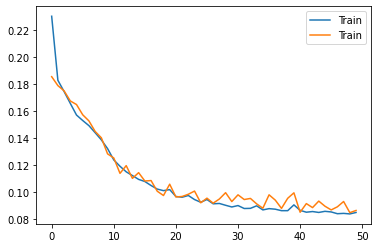

Running LSTM based on independent and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Individual')
0.08693633005023002


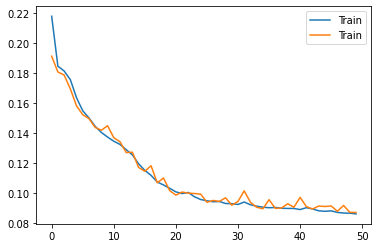

Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Combined')
0.08624519805113474


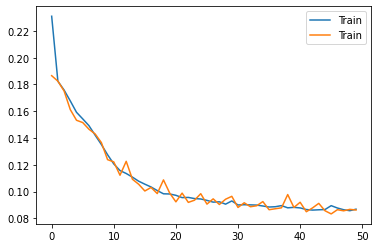

Running LSTM based on independent and Multi FC, with dataset using ('combined', 'freq') ('raw', 'Combined')
0.09107793569564819


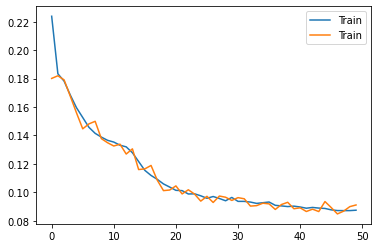

Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'None')
0.0914115568002065


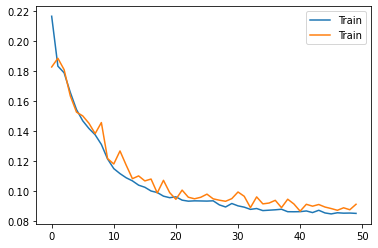

Running LSTM based on independent and Multi FC, with dataset using ('combined', 'freq') ('raw', 'None')
0.1021749292810758


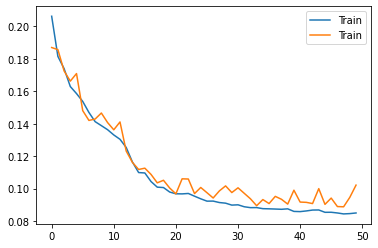

Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Individual')
0.08793292194604874


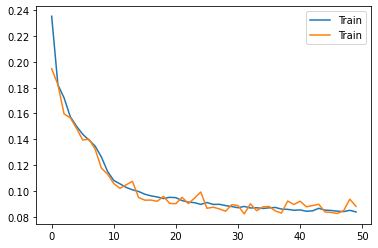

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Individual')
0.08291851927836737


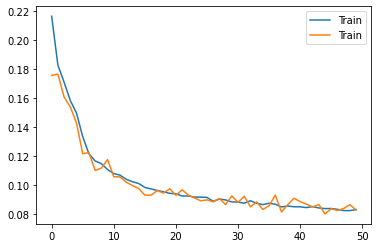

Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Combined')
0.08474297722180685


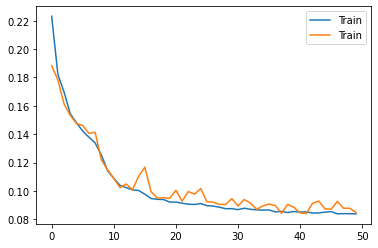

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', 'Combined')
0.08575732285777728


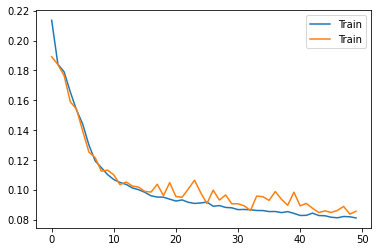

Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'None')
0.08326209982236227


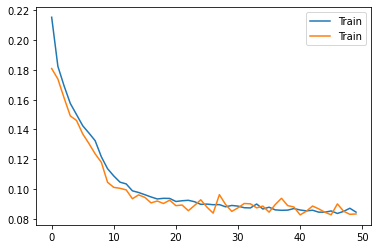

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', 'None')
0.08206577450037003


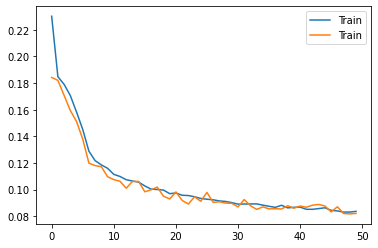

Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Individual')
0.08303826451301574


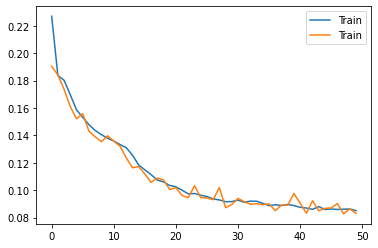

Running LSTM based on independent and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Individual')
0.08699323683977127


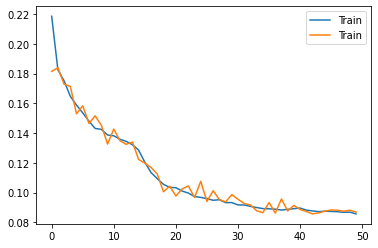

Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Combined')
0.09110716233650844


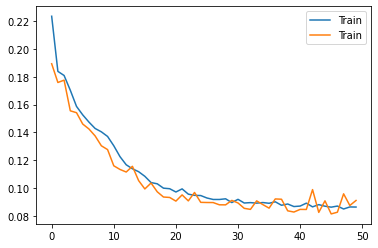

Running LSTM based on independent and Multi FC, with dataset using ('combined', 'natural') ('raw', 'Combined')
0.0847531740864118


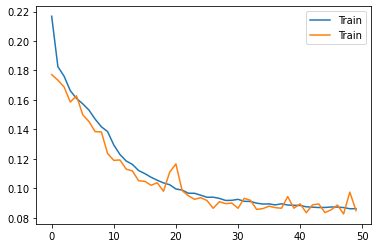

Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'None')
0.08546456744273503


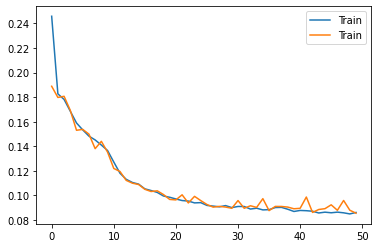

Running LSTM based on independent and Multi FC, with dataset using ('combined', 'natural') ('raw', 'None')
0.0998841255903244


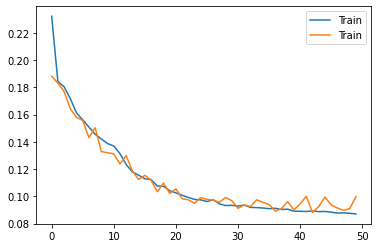

Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Individual')
0.08244196648399035


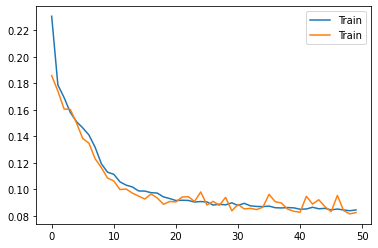

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Individual')
0.08651616623004278


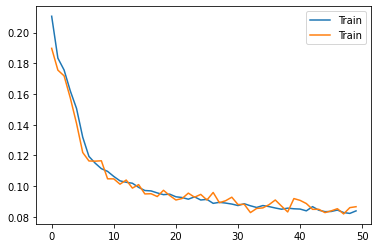

Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Combined')
0.08671792397896448


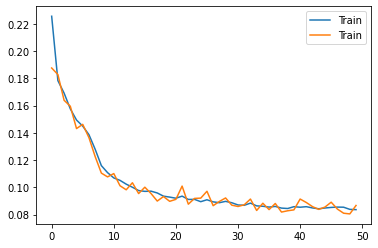

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('raw', 'Combined')
0.08033336736261845


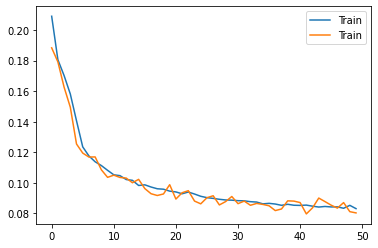

Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'None')
0.088237331310908


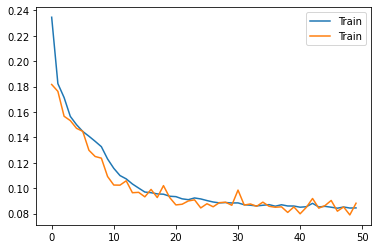

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('raw', 'None')
0.08926664094130198


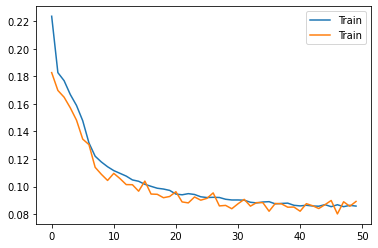

In [11]:
for model_type in non_comb_losses.keys():
    
    for comb in non_comb_losses[model_type].keys():
        
        for ext_method in non_comb_losses[model_type][comb].keys():
            
            for fc_type in ['Multi FC']:
               
                if len(ext_method) == 2 and ext_method[0] == 'raw':
                    for model_method in non_comb_losses[model_type][comb][ext_method][fc_type].keys():
                        if model_method == "multi_channel":
                            continue
                        train, test = non_comb_losses[model_type][comb][ext_method][fc_type][model_method]['Train Loss'], \
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method]['Validation Loss']
                        plt.plot(
                            range(len(train)), train,
                            label="Train"
                            )
                        plt.plot(
                            range(len(test)), test,
                            label="Train"
                            )
                        print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                        print(test[-1])
                        plt.legend()
                        plt.show()

In [ ]:
models['LSTM'][('combined', 'freq')].keys()

In [ ]:
accuracies = {}

for model_type in models.keys():
    accuracies[model_type] = {}
    for comb in models[model_type].keys():
        accuracies[model_type][comb] = {}
        for ext_method in ['raw', 'entropy', 'energy', 'combined']:
            for fc_type in ['Single FC', 'Multi FC']:
                
                for model_method in ['concatenate', 'multi_channel', 'independent']:
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb}")
                    
                    for norm in ['Combined']:
                        accuracies[model_type][comb][(ext_method, norm)] = {}
                        accuracies[model_type][comb][(ext_method, norm)][fc_type] = {}
                        
                        acc = test(
                                  loaders[comb][(ext_method, norm)]['test'],
                                  models[model_type][comb][(ext_method, norm)][fc_type][model_method],
                                  all_datasets[comb][(ext_method, norm)][0])
                        print(norm, ": ",
                              acc,
                              "%\n")
                        
                        accuracies[model_type][comb][(ext_method, norm)][fc_type][model_method] = acc
                        


In [ ]:
l.keys()

In [63]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Single FC', 'Multi FC']:
                
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    if model_method not in 
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    l = comb_losses if comb == "Combined" else non_comb_losses
                    train = l[model_type][comb][ext_method][fc_type][model_method]['Train Loss']
                    val = l[model_type][comb][ext_method][fc_type][model_method]['Validation Loss']
                    x = rangle(len(train))
                    plt.plot(x, train, label="Train")
                    plt.plot(x, val, label="Test")
                    plt.show()

SyntaxError: invalid syntax (2267075087.py, line 7)

Concatenate performed the best, multi_channel overfitted like crazy.

Not much difference between frequency and combined.

Not much difference between combining of seperating the signals for WPD.

- Test other metrics on concatenated LSTM 

 # Test all concatenate

In [25]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('raw', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 155.56batch/s, counter=8, epoch=135, lastLoss=0.0827, valLoss=0.0848]


100%|██████████████████████| 56/56 [00:00<00:00, 155.13batch/s, counter=49, epoch=176, lastLoss=0.0807, valLoss=0.0899]


Early stopping after 177 epochs
Average train loss: 0.02280662851208555
Average validation loss: 0.023289478505296366
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('energy', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 251.94batch/s, counter=49, epoch=80, lastLoss=0.158, valLoss=0.163]


Early stopping after 81 epochs
Average train loss: 0.0190629890293111
Average validation loss: 0.019404908705325356
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('entropy', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 261.08batch/s, counter=7, epoch=135, lastLoss=0.0821, valLoss=0.0862]


100%|██████████████████████| 56/56 [00:00<00:00, 261.07batch/s, counter=18, epoch=271, lastLoss=0.0708, valLoss=0.0724]


100%|██████████████████████| 56/56 [00:00<00:00, 272.52batch/s, counter=49, epoch=385, lastLoss=0.0672, valLoss=0.0717]


Early stopping after 386 epochs
Average train loss: 0.04497004357888839
Average validation loss: 0.04717894854396582
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('min-max', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 232.85batch/s, counter=7, epoch=135, lastLoss=0.109, valLoss=0.124]


100%|██████████████████████| 56/56 [00:00<00:00, 230.46batch/s, counter=15, epoch=271, lastLoss=0.0932, valLoss=0.0958]


100%|███████████████████████| 56/56 [00:00<00:00, 272.69batch/s, counter=12, epoch=407, lastLoss=0.0858, valLoss=0.095]


100%|███████████████████████| 56/56 [00:00<00:00, 276.50batch/s, counter=0, epoch=543, lastLoss=0.0779, valLoss=0.0811]


100%|██████████████████████| 56/56 [00:00<00:00, 258.11batch/s, counter=49, epoch=649, lastLoss=0.0741, valLoss=0.0847]


Early stopping after 650 epochs
Average train loss: 0.08965112451958109
Average validation loss: 0.09399669759578647
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 84.02batch/s, counter=2, epoch=135, lastLoss=0.0784, valLoss=0.0787]


100%|███████████████████████| 56/56 [00:00<00:00, 88.54batch/s, counter=14, epoch=271, lastLoss=0.0535, valLoss=0.0585]


100%|███████████████████████| 56/56 [00:00<00:00, 84.66batch/s, counter=49, epoch=306, lastLoss=0.0477, valLoss=0.0557]


Early stopping after 307 epochs
Average train loss: 0.030700154341947363
Average validation loss: 0.032869105871412015
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('energy', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 266.51batch/s, counter=2, epoch=135, lastLoss=0.143, valLoss=0.144]


100%|████████████████████████| 56/56 [00:00<00:00, 273.85batch/s, counter=49, epoch=236, lastLoss=0.131, valLoss=0.133]


Early stopping after 237 epochs
Average train loss: 0.05074521814967146
Average validation loss: 0.05088126717720712
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 248.90batch/s, counter=0, epoch=135, lastLoss=0.0769, valLoss=0.0731]


100%|██████████████████████| 56/56 [00:00<00:00, 244.55batch/s, counter=10, epoch=271, lastLoss=0.0512, valLoss=0.0591]


100%|██████████████████████| 56/56 [00:00<00:00, 271.62batch/s, counter=47, epoch=407, lastLoss=0.0471, valLoss=0.0541]


100%|██████████████████████| 56/56 [00:00<00:00, 281.84batch/s, counter=49, epoch=409, lastLoss=0.0465, valLoss=0.0512]


Early stopping after 410 epochs
Average train loss: 0.03881879384006962
Average validation loss: 0.04048526391874821
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('min-max', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 266.67batch/s, counter=4, epoch=135, lastLoss=0.0843, valLoss=0.0859]


100%|██████████████████████| 56/56 [00:00<00:00, 237.30batch/s, counter=49, epoch=239, lastLoss=0.0813, valLoss=0.0926]


Early stopping after 240 epochs
Average train loss: 0.03202682271020068
Average validation loss: 0.03346321610698388
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('raw', 'None')
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 162.09batch/s, counter=44, epoch=135, lastLoss=0.0815, valLoss=0.0834]


100%|██████████████████████| 56/56 [00:00<00:00, 147.57batch/s, counter=49, epoch=140, lastLoss=0.0797, valLoss=0.0915]


Early stopping after 141 epochs
Average train loss: 0.01845982364302843
Average validation loss: 0.01900292844431741
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('energy', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 286.80batch/s, counter=49, epoch=117, lastLoss=0.158, valLoss=0.161]


Early stopping after 118 epochs
Average train loss: 0.02751178163388858
Average validation loss: 0.02783425988540763
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('entropy', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 247.23batch/s, counter=1, epoch=135, lastLoss=0.0862, valLoss=0.0939]


100%|██████████████████████| 56/56 [00:00<00:00, 250.58batch/s, counter=15, epoch=271, lastLoss=0.0737, valLoss=0.0756]


100%|██████████████████████| 56/56 [00:00<00:00, 274.60batch/s, counter=44, epoch=407, lastLoss=0.0648, valLoss=0.0743]


100%|██████████████████████| 56/56 [00:00<00:00, 285.87batch/s, counter=49, epoch=412, lastLoss=0.0646, valLoss=0.0716]


Early stopping after 413 epochs
Average train loss: 0.049118142424778514
Average validation loss: 0.051712127482784656
Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'natural') ('min-max', 'None')
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 244.02batch/s, counter=2, epoch=135, lastLoss=0.103, valLoss=0.105]


100%|███████████████████████| 56/56 [00:00<00:00, 244.53batch/s, counter=5, epoch=271, lastLoss=0.0879, valLoss=0.0971]


100%|██████████████████████| 56/56 [00:00<00:00, 269.24batch/s, counter=11, epoch=407, lastLoss=0.0816, valLoss=0.0839]


100%|██████████████████████| 56/56 [00:00<00:00, 249.45batch/s, counter=49, epoch=445, lastLoss=0.0846, valLoss=0.0926]


Early stopping after 446 epochs
Average train loss: 0.06266389926809969
Average validation loss: 0.06524708376833725
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('raw', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 95.73batch/s, counter=49, epoch=134, lastLoss=0.0805, valLoss=0.0868]


Early stopping after 135 epochs
Average train loss: 0.017379056890590158
Average validation loss: 0.01767047698866753
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('energy', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 290.18batch/s, counter=49, epoch=105, lastLoss=0.157, valLoss=0.155]


Early stopping after 106 epochs
Average train loss: 0.024666250507746425
Average validation loss: 0.024737372962846647
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 280.85batch/s, counter=0, epoch=135, lastLoss=0.0649, valLoss=0.0623]


100%|███████████████████████| 56/56 [00:00<00:00, 282.82batch/s, counter=7, epoch=271, lastLoss=0.0523, valLoss=0.0552]


100%|██████████████████████| 56/56 [00:00<00:00, 274.61batch/s, counter=49, epoch=366, lastLoss=0.0479, valLoss=0.0523]


Early stopping after 367 epochs
Average train loss: 0.03464483023782698
Average validation loss: 0.03497581780693006
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('min-max', 'None')
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 281.04batch/s, counter=32, epoch=135, lastLoss=0.0861, valLoss=0.0902]


100%|███████████████████████| 56/56 [00:00<00:00, 284.71batch/s, counter=49, epoch=255, lastLoss=0.0817, valLoss=0.082]

Early stopping after 256 epochs
Average train loss: 0.034513743967578114
Average validation loss: 0.03443371814533713


In [28]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Multi FC']:

                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method}")
                    print(test(
                        loaders[comb][ext_method]['test'],
                        models[model_type][comb][ext_method][fc_type][model_method], all_datasets[comb][ext_method][1]), "\n")

Running LSTM based on concatenate, with dataset using ('combined', 'freq') ('raw', 'None')
(87.31335258483887, array([94.374565, 59.829823, 99.71573 , 99.33205 , 82.002365, 88.62559 ],
      dtype=float32), 0.08897917071978251) 

Running LSTM based on concatenate, with dataset using ('combined', 'freq') ('energy', 'None')
(43.27786636352539, array([ 92.38111 ,  54.558846,  99.692024,  99.13908 , -42.624542,
       -43.47934 ], dtype=float32), 0.16247588892777762) 

Running LSTM based on concatenate, with dataset using ('combined', 'freq') ('entropy', 'None')
(89.9098310470581, array([94.52349, 74.47838, 99.74379, 99.60518, 80.18895, 90.9192 ],
      dtype=float32), 0.06856744537750879) 

Running LSTM based on concatenate, with dataset using ('combined', 'freq') ('min-max', 'None')
(87.6575756072998, array([94.3436  , 68.6983  , 99.72671 , 99.496025, 79.08258 , 84.59824 ],
      dtype=float32), 0.07982741768161455) 

Running LSTM based on concatenate, with dataset using ('separated', 'n

Both natural and frequency order work well.

Seperated worked the best
- Retry energy and min-max with seperated
- Test statistics
- Frequency slightly better but 2/3 of the best were natural
- Use seperated as they had the best performance but 2/3

Best:
- LSTM based on concatenate, with dataset using ('separated', 'natural') ('raw', 'None')
    - 92% MAPE, 0.056 MAE
- LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', 'None')
    - 92% MAPE, 0.054 MAE
- LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', 'None')
    - 93% MAPE, 0.049 MAE
 

# Normalised coefficients for energy + all standard statistics (mean, std)

In [66]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', 'mean_std')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 244.54batch/s, counter=6, epoch=135, lastLoss=0.0938, valLoss=0.0878]


100%|██████████████████████| 56/56 [00:00<00:00, 269.19batch/s, counter=49, epoch=223, lastLoss=0.0876, valLoss=0.0837]


Early stopping after 224 epochs
Average train loss: 0.033598456323640995
Average validation loss: 0.03254017942398787
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('energy', 'None', 'mean_std')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 286.46batch/s, counter=8, epoch=135, lastLoss=0.0969, valLoss=0.0987]


100%|██████████████████████| 56/56 [00:00<00:00, 256.78batch/s, counter=15, epoch=271, lastLoss=0.0862, valLoss=0.0913]


100%|██████████████████████| 56/56 [00:00<00:00, 282.44batch/s, counter=49, epoch=360, lastLoss=0.0826, valLoss=0.0842]

Early stopping after 361 epochs
Average train loss: 0.04824850612719144
Average validation loss: 0.049904667877370405


In [67]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Multi FC']:

                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method}")
                    print(test(
                        loaders[comb][ext_method]['test'],
                        models[model_type][comb][ext_method][fc_type][model_method], all_datasets[comb][ext_method][1]), "\n")

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean_std')
(87.77099895477295, array([94.5212  , 61.962856, 99.73651 , 99.423775, 76.28084 , 94.70081 ],
      dtype=float32), 0.08133918841679891) 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('energy', 'None', 'mean_std')
(87.16162300109863, array([93.94509 , 71.93136 , 99.736   , 99.465965, 68.51663 , 89.374695],
      dtype=float32), 0.08683206538359324) 



Energy seems to perform reasonably well now.
Statistics also perform reasonably well.
Wasnt as competative as compared to others.

- Test different combinations of statistics
- Test min-max with normalisation

# Combinations of stats + min-max with normalisation

In [73]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 279.19batch/s, counter=0, epoch=135, lastLoss=0.0915, valLoss=0.0833]


100%|██████████████████████| 56/56 [00:00<00:00, 277.82batch/s, counter=33, epoch=271, lastLoss=0.0844, valLoss=0.0837]


100%|████████████████████████| 56/56 [00:00<00:00, 276.36batch/s, counter=49, epoch=287, lastLoss=0.0862, valLoss=0.08]


Early stopping after 288 epochs
Average train loss: 0.04107649728465749
Average validation loss: 0.04074017786083832
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 263.55batch/s, counter=15, epoch=135, lastLoss=0.0286, valLoss=0.068]


100%|██████████████████████| 56/56 [00:00<00:00, 263.21batch/s, counter=49, epoch=169, lastLoss=0.0236, valLoss=0.0637]


Early stopping after 170 epochs
Average train loss: 0.010770946375156125
Average validation loss: 0.01799699024811742
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew kurtosis')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 223.80batch/s, counter=0, epoch=135, lastLoss=0.0247, valLoss=0.0632]


100%|██████████████████████| 56/56 [00:00<00:00, 223.23batch/s, counter=49, epoch=187, lastLoss=0.0207, valLoss=0.0672]


Early stopping after 188 epochs
Average train loss: 0.01042875091488264
Average validation loss: 0.019438194682732935
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 268.64batch/s, counter=1, epoch=135, lastLoss=0.0672, valLoss=0.0725]


100%|███████████████████████| 56/56 [00:00<00:00, 279.91batch/s, counter=2, epoch=271, lastLoss=0.0611, valLoss=0.0668]


100%|██████████████████████| 56/56 [00:00<00:00, 270.89batch/s, counter=49, epoch=350, lastLoss=0.0549, valLoss=0.0691]

Early stopping after 351 epochs
Average train loss: 0.03450342139846892
Average validation loss: 0.03923496630548367


In [76]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Multi FC']:

                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method}")
                    
                    validation = test(
                            loaders[comb][ext_method]['test'],
                            models[model_type][comb][ext_method][fc_type][model_method],
                            all_datasets[comb][ext_method][1]
                    )
                    
                    print(
                        "Final training loss: ",
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method]['Train Loss'][-1]
                    )
                    print(
                        f"MAPE: {validation[0]}, MAE: {validation[2]}", "\n"
                    )

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std')
Final training loss:  0.08467330650559493
MAPE: 85.29463195800781, MAE: 0.08479236314694087 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew')
Final training loss:  0.02411688954037215
MAPE: 89.22906875610352, MAE: 0.06660151407122612 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew kurtosis')
Final training loss:  0.0211575709482921
MAPE: 90.1204662322998, MAE: 0.0665551965435346 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Final training loss:  0.054078560056430955
MAPE: 90.59706115722656, MAE: 0.07157569999496143 



In [75]:
all_datasets[('separated', 'freq')].keys()

dict_keys([('stats', 'None', 'mean std'), ('stats', 'None', 'mean std skew'), ('stats', 'None', 'mean std skew kurtosis'), ('min-max', 'None', 'None')])

Many seem to overfit but have reasonable validation loss and very low training loss.
The training loss is the best achieved so far - regularisation should help validation loss.

Combinations of statistics which were effective:
- Mean, std, skew
- Mean, std, skew, kurtosis

Best:
- LSTM based on concatenate, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
    - 90.5% MAPE, 0.07 MAE, last loss: 0.05
- LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew kurtosis')
    - 90.1% MAPE, 0.066 MAE, last loss: 0.02
- Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', 'mean std skew')
    - 89% MAPE, 0.066 MAE, last loss: 0.02
    
Also tested on combined:
- LSTM concatenate, with dataset using ('combined', 'freq') ('stats', 'None', 'mean_std_skew')
    - 91.7% MAPE, 0.062 MAE, final training loss: 0.023
- LSTM concatenate, with dataset using ('combined', 'freq') ('stats', 'None', 'mean_std_skew_kurtosis')
    - 90% MAPE, 0.06 MAE, final training loss: 0.023
- LSTM based on concatenate, with dataset using ('combined', 'freq') ('min-max', 'None')
    - 91% MAPE, 0.04 MAE, final training loss: 0.047

Overall:
- Mean and std not effective on their own
- Mean, std, skew kurtosis performed better with seperated but worse with combined
    - Probably random
    - Nearly 3% increase in seperated using combined, std and skew
- Min-max performs better with normalisation


# Overall
Top 3:
- LSTM based on concatenate, with dataset using ('separated', 'natural') ('raw', 'None')
    - 92% MAPE, 0.056 MAE
- LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', 'None')
    - 92% MAPE, 0.054 MAE
- LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', 'None')
    - 93% MAPE, 0.049 MAE
 
Better than CNN + LSTM top 3.

# Regularisation on networks with competative accuracy but high overfitting (very low training loss)

In [134]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 227.66batch/s, counter=34, epoch=135, lastLoss=0.0618, valLoss=0.068]


100%|██████████████████████| 56/56 [00:00<00:00, 260.76batch/s, counter=49, epoch=150, lastLoss=0.0604, valLoss=0.0671]


Early stopping after 151 epochs
Average train loss: 0.015976752509477034
Average validation loss: 0.016338075493418036
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 219.79batch/s, counter=31, epoch=135, lastLoss=0.0641, valLoss=0.0769]


100%|██████████████████████| 56/56 [00:00<00:00, 220.66batch/s, counter=49, epoch=153, lastLoss=0.0628, valLoss=0.0845]


Early stopping after 154 epochs
Average train loss: 0.01695754730437255
Average validation loss: 0.01886072108309184
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew'))
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 255.72batch/s, counter=49, epoch=124, lastLoss=0.0673, valLoss=0.0707]


Early stopping after 125 epochs
Average train loss: 0.014677651852217255
Average validation loss: 0.014628215519800073
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None,', ('mean', 'std', 'skew'))
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 251.73batch/s, counter=49, epoch=131, lastLoss=0.0639, valLoss=0.0892]


Early stopping after 132 epochs
Average train loss: 0.015140079155051132
Average validation loss: 0.015787687785213902
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 266.77batch/s, counter=13, epoch=135, lastLoss=0.0916, valLoss=0.0856]


100%|██████████████████████| 56/56 [00:00<00:00, 268.62batch/s, counter=30, epoch=271, lastLoss=0.0864, valLoss=0.0726]


100%|██████████████████████| 56/56 [00:00<00:00, 272.76batch/s, counter=49, epoch=290, lastLoss=0.0829, valLoss=0.0749]

Early stopping after 291 epochs
Average train loss: 0.03978838128560432
Average validation loss: 0.035737600986446655


Seems to be underfitting -> increase capacity of network

## Test more layers

In [141]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.0001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 231.48batch/s, counter=1, epoch=135, lastLoss=0.0782, valLoss=0.0713]


100%|██████████████████████| 56/56 [00:00<00:00, 230.04batch/s, counter=49, epoch=251, lastLoss=0.0694, valLoss=0.0648]


Early stopping after 252 epochs
Average train loss: 0.0316298200330716
Average validation loss: 0.027613234007198895
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 186.80batch/s, counter=3, epoch=135, lastLoss=0.0781, valLoss=0.076]


100%|██████████████████████| 56/56 [00:00<00:00, 190.49batch/s, counter=49, epoch=232, lastLoss=0.0706, valLoss=0.0706]


Early stopping after 233 epochs
Average train loss: 0.029836451913116083
Average validation loss: 0.02837119937351062
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew'))
Using: cuda


100%|██████████████████████| 56/56 [00:00<00:00, 221.05batch/s, counter=12, epoch=135, lastLoss=0.0856, valLoss=0.0787]


100%|██████████████████████| 56/56 [00:00<00:00, 227.19batch/s, counter=20, epoch=271, lastLoss=0.0725, valLoss=0.0666]


100%|██████████████████████| 56/56 [00:00<00:00, 229.51batch/s, counter=49, epoch=402, lastLoss=0.0687, valLoss=0.0641]


Early stopping after 403 epochs
Average train loss: 0.049632818993009926
Average validation loss: 0.04546579818392083
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None,', ('mean', 'std', 'skew'))
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 220.64batch/s, counter=2, epoch=135, lastLoss=0.0852, valLoss=0.0772]


100%|██████████████████████| 56/56 [00:00<00:00, 205.54batch/s, counter=18, epoch=271, lastLoss=0.0736, valLoss=0.0776]


100%|██████████████████████| 56/56 [00:00<00:00, 226.31batch/s, counter=49, epoch=362, lastLoss=0.0696, valLoss=0.0725]


Early stopping after 363 epochs
Average train loss: 0.0460481104778354
Average validation loss: 0.042272023258109886
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 214.57batch/s, counter=7, epoch=135, lastLoss=0.101, valLoss=0.0857]


100%|██████████████████████| 56/56 [00:00<00:00, 242.07batch/s, counter=22, epoch=271, lastLoss=0.0907, valLoss=0.0838]


100%|██████████████████████| 56/56 [00:00<00:00, 240.87batch/s, counter=13, epoch=407, lastLoss=0.0852, valLoss=0.0707]


100%|██████████████████████| 56/56 [00:00<00:00, 228.40batch/s, counter=49, epoch=443, lastLoss=0.0829, valLoss=0.0756]

Early stopping after 444 epochs
Average train loss: 0.06346569356679613
Average validation loss: 0.05420227637088725


In [142]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Multi FC']:

                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method}")
                    
                    validation = test(
                            loaders[comb][ext_method]['test'],
                            models[model_type][comb][ext_method][fc_type][model_method],
                            all_datasets[comb][ext_method][1]
                    )
                    
                    print(
                        "Final training loss: ",
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method]['Train Loss'][-1]
                    )
                    print(
                        f"MAPE: {validation[0]}, MAE: {validation[2]}", "\n"
                    )

Running LSTM based on concatenate, with dataset using ('combined', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Final training loss:  0.07067237947402256
MAPE: 87.88941669464111, MAE: 0.06566950976848603 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Final training loss:  0.07008894752444965
MAPE: 88.35798454284668, MAE: 0.06990430429577828 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew'))
Final training loss:  0.06872066895344428
MAPE: 89.2452745437622, MAE: 0.06947272568941117 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None,', ('mean', 'std', 'skew'))
Final training loss:  0.06922772147559694
MAPE: 89.06711387634277, MAE: 0.06757414564490319 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Final training loss: 

Not learning effectively even with decreased learning rate

## Add more hidden units in LSTM

In [146]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.0001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('combined', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 247.93batch/s, counter=7, epoch=135, lastLoss=0.0781, valLoss=0.0701]


100%|██████████████████████| 56/56 [00:00<00:00, 236.22batch/s, counter=19, epoch=271, lastLoss=0.0664, valLoss=0.0648]


100%|███████████████████████| 56/56 [00:00<00:00, 249.86batch/s, counter=49, epoch=364, lastLoss=0.0638, valLoss=0.064]


Early stopping after 365 epochs
Average train loss: 0.04136265225508916
Average validation loss: 0.03796827510256498
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 146.41batch/s, counter=7, epoch=135, lastLoss=0.0741, valLoss=0.0773]


100%|███████████████████████| 56/56 [00:00<00:00, 138.11batch/s, counter=0, epoch=271, lastLoss=0.0636, valLoss=0.0678]


100%|██████████████████████| 56/56 [00:00<00:00, 145.27batch/s, counter=49, epoch=381, lastLoss=0.0583, valLoss=0.0685]


Early stopping after 382 epochs
Average train loss: 0.04135758381783582
Average validation loss: 0.04339183562408601
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew'))
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 202.17batch/s, counter=6, epoch=135, lastLoss=0.0857, valLoss=0.0829]


100%|███████████████████████| 56/56 [00:00<00:00, 195.47batch/s, counter=4, epoch=271, lastLoss=0.0732, valLoss=0.0699]


100%|██████████████████████| 56/56 [00:00<00:00, 197.54batch/s, counter=49, epoch=329, lastLoss=0.0689, valLoss=0.0739]


Early stopping after 330 epochs
Average train loss: 0.04186445650635097
Average validation loss: 0.038523651717851555
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('stats', 'None,', ('mean', 'std', 'skew'))
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 176.66batch/s, counter=3, epoch=135, lastLoss=0.0855, valLoss=0.08]


100%|███████████████████████| 56/56 [00:00<00:00, 196.50batch/s, counter=14, epoch=271, lastLoss=0.072, valLoss=0.0716]


100%|███████████████████████| 56/56 [00:00<00:00, 192.78batch/s, counter=49, epoch=341, lastLoss=0.069, valLoss=0.0724]


Early stopping after 342 epochs
Average train loss: 0.043205530986817064
Average validation loss: 0.04025323386135556
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 257.54batch/s, counter=6, epoch=135, lastLoss=0.102, valLoss=0.0893]


100%|███████████████████████| 56/56 [00:00<00:00, 252.33batch/s, counter=4, epoch=271, lastLoss=0.0918, valLoss=0.0804]


100%|████████████████████████| 56/56 [00:00<00:00, 256.46batch/s, counter=5, epoch=407, lastLoss=0.085, valLoss=0.0754]


100%|██████████████████████| 56/56 [00:00<00:00, 252.22batch/s, counter=49, epoch=451, lastLoss=0.0839, valLoss=0.0778]

Early stopping after 452 epochs
Average train loss: 0.06424708757340453
Average validation loss: 0.05510549257101403


In [147]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Multi FC']:

                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method}")
                    
                    validation = test(
                            loaders[comb][ext_method]['test'],
                            models[model_type][comb][ext_method][fc_type][model_method],
                            all_datasets[comb][ext_method][1]
                    )
                    
                    print(
                        "Final training loss: ",
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method]['Train Loss'][-1]
                    )
                    print(
                        f"MAPE: {validation[0]}, MAE: {validation[2]}", "\n"
                    )

Running LSTM based on concatenate, with dataset using ('combined', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Final training loss:  0.06297065756682839
MAPE: 88.25880146026611, MAE: 0.0652707206706206 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew', 'kurtosis'))
Final training loss:  0.05770758047167744
MAPE: 87.3675889968872, MAE: 0.07161040554443995 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None', ('mean', 'std', 'skew'))
Final training loss:  0.06917461619845458
MAPE: 89.19272994995117, MAE: 0.07059050798416137 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('stats', 'None,', ('mean', 'std', 'skew'))
Final training loss:  0.06761227282030242
MAPE: 88.58627319335938, MAE: 0.07341788510481516 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('min-max', 'None', 'None')
Final training loss:  

Same result again. One of them got 86%, so could be potential but the top 3 nextworks can also be optimised so this shouldn't be persued any longer

# Test Concatenate vs. individual (siamese) on top 3

Top 3:

- LSTM based on concatenate, with dataset using ('separated', 'natural') ('raw', 'None')
    - 92% MAPE, 0.056 MAE
- LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', 'None')
    - 92% MAPE, 0.054 MAE
- LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', 'None')
    - 93% MAPE, 0.049 MAE

Better than CNN + LSTM top 3.

In [158]:
comb_losses = {}
non_comb_losses = {}

for model_type in models.keys():
    non_comb_losses[model_type] = {}
    comb_losses[model_type] = {}
    
    for comb in models[model_type].keys():
        non_comb_losses[model_type][comb] = {}
        comb_losses[model_type][comb] = {}
        
        for ext_method in models[model_type][comb].keys():
            non_comb_losses[model_type][comb][ext_method] = {}
            comb_losses[model_type][comb][ext_method] = {}
            
            for fc_type in ['Multi FC']:
                non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                comb_losses[model_type][comb][ext_method][fc_type] = {}
                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}")
                    train_loss, val_loss = train(
                        loaders[comb][ext_method]['train'],
                        models[model_type][comb][ext_method][fc_type][model_method],
                        val_loader=loaders[comb][ext_method]['test'],
                        LR=0.0001,
                        epochs=700,
                        early_stopping=True,
                        patience=50
                    )

                    # Stop at 50 epochs
                    # Only add if last lost had potential
                    if comb == "Combined":
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }
                    else:
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {
                            'Train Loss': train_loss,
                            'Validation Loss': val_loss
                        }


Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 96.55batch/s, counter=0, epoch=135, lastLoss=0.0921, valLoss=0.0855]


100%|███████████████████████| 56/56 [00:00<00:00, 96.97batch/s, counter=16, epoch=271, lastLoss=0.0837, valLoss=0.0878]


100%|███████████████████████| 56/56 [00:00<00:00, 96.97batch/s, counter=49, epoch=338, lastLoss=0.0823, valLoss=0.0847]


Early stopping after 339 epochs
Average train loss: 0.04907543683491115
Average validation loss: 0.047833370691697505
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 85.63batch/s, counter=1, epoch=135, lastLoss=0.0952, valLoss=0.0954]


100%|████████████████████████| 56/56 [00:00<00:00, 85.83batch/s, counter=0, epoch=271, lastLoss=0.0855, valLoss=0.0793]


100%|████████████████████████| 56/56 [00:00<00:00, 83.03batch/s, counter=0, epoch=407, lastLoss=0.0807, valLoss=0.0749]


100%|████████████████████████| 56/56 [00:00<00:00, 86.35batch/s, counter=4, epoch=543, lastLoss=0.0692, valLoss=0.0734]


100%|████████████████████████| 56/56 [00:00<00:00, 87.03batch/s, counter=7, epoch=679, lastLoss=0.0569, valLoss=0.0583]


100%|████████████████████████| 56/56 [00:00<00:00, 86.36batch/s, counter=0, epoch=699, lastLoss=0.0554, valLoss=0.0534]


Average train loss: 0.08626703885326883
Average validation loss: 0.08461779283834178
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None')
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 290.36batch/s, counter=6, epoch=135, lastLoss=0.0975, valLoss=0.0907]


100%|██████████████████████| 56/56 [00:00<00:00, 286.24batch/s, counter=15, epoch=271, lastLoss=0.0881, valLoss=0.0842]


100%|██████████████████████| 56/56 [00:00<00:00, 289.52batch/s, counter=49, epoch=402, lastLoss=0.0852, valLoss=0.0803]


Early stopping after 403 epochs
Average train loss: 0.05931259429053765
Average validation loss: 0.05741795113860142
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 236.55batch/s, counter=0, epoch=135, lastLoss=0.101, valLoss=0.0924]


100%|██████████████████████| 56/56 [00:00<00:00, 241.61batch/s, counter=12, epoch=271, lastLoss=0.0885, valLoss=0.0867]


100%|███████████████████████| 56/56 [00:00<00:00, 238.08batch/s, counter=49, epoch=385, lastLoss=0.085, valLoss=0.0819]


Early stopping after 386 epochs
Average train loss: 0.05808286357290891
Average validation loss: 0.05613060607299918
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 277.57batch/s, counter=4, epoch=135, lastLoss=0.0964, valLoss=0.096]


100%|███████████████████████| 56/56 [00:00<00:00, 281.39batch/s, counter=0, epoch=271, lastLoss=0.0875, valLoss=0.0837]


100%|███████████████████████| 56/56 [00:00<00:00, 281.09batch/s, counter=2, epoch=407, lastLoss=0.0841, valLoss=0.0825]


100%|██████████████████████| 56/56 [00:00<00:00, 286.42batch/s, counter=49, epoch=473, lastLoss=0.0831, valLoss=0.0826]


Early stopping after 474 epochs
Average train loss: 0.06760104445312932
Average validation loss: 0.0672529392096968
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None')
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 230.35batch/s, counter=0, epoch=135, lastLoss=0.103, valLoss=0.0985]


100%|███████████████████████| 56/56 [00:00<00:00, 238.90batch/s, counter=6, epoch=271, lastLoss=0.0893, valLoss=0.0874]


100%|███████████████████████| 56/56 [00:00<00:00, 236.79batch/s, counter=24, epoch=407, lastLoss=0.0854, valLoss=0.087]


100%|██████████████████████| 56/56 [00:00<00:00, 230.50batch/s, counter=49, epoch=469, lastLoss=0.0842, valLoss=0.0843]

Early stopping after 470 epochs
Average train loss: 0.06943665859279964
Average validation loss: 0.06905609290674328


In [159]:
for model_type in models.keys():
    for comb in models[model_type].keys():
        
        for ext_method in models[model_type][comb].keys():
            for fc_type in ['Multi FC']:

                for model_method in models[model_type][comb][ext_method][fc_type].keys():
                    print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method}")
                    
                    validation = test(
                            loaders[comb][ext_method]['test'],
                            models[model_type][comb][ext_method][fc_type][model_method],
                            all_datasets[comb][ext_method][1]
                    )
                    
                    print(
                        "Final training loss: ",
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method]['Train Loss'][-1]
                    )
                    print(
                        f"MAPE: {validation[0]}, MAE: {validation[2]}", "\n"
                    )

Running LSTM based on concatenate, with dataset using ('separated', 'natural') ('raw', False, 'None')
Final training loss:  0.08224039844104222
MAPE: 88.38942527770996, MAE: 0.07860800648729006 

Running LSTM based on independent, with dataset using ('separated', 'natural') ('raw', False, 'None')
Final training loss:  0.05644954328558275
MAPE: 91.74589538574219, MAE: 0.058181552588939665 

Running LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', False, 'None')
Final training loss:  0.0851908235677651
MAPE: 86.17772579193115, MAE: 0.08746363570292791 

Running LSTM based on independent, with dataset using ('separated', 'natural') ('entropy', False, 'None')
Final training loss:  0.08480741881898471
MAPE: 83.83171844482422, MAE: 0.08517775684595108 

Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', False, 'None')
Final training loss:  0.08307809475809336
MAPE: 86.62028121948242, MAE: 0.08226583749055863 

Running LST

Best 3:
- LSTM based on independent, ('separated', 'natural') ('raw', False, 'None')
- Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', False, 'None')
- LSTM based on concatenate, ('separated', 'natural') ('entropy', False, 'None')

Accuracy less -> stochastic nature of ML.
Should do KFCV but not enough time

In [147]:
def test_models(model_type=None):
    for model_type in models.keys() if not model_type else [model_type]:
        for comb in models[model_type].keys():

            for ext_method in models[model_type][comb].keys():
                for fc_type in ['Multi FC']:

                    for model_method in models[model_type][comb][ext_method][fc_type].keys():
                        for output in models[model_type][comb][ext_method][fc_type][model_method].keys():
                            print(f"Running {model_type} based on {model_method}, with dataset using {comb} {ext_method} using {output}")

                            validation = test(
                                    loaders[comb][ext_method]['test'],
                                    models[model_type][comb][ext_method][fc_type][model_method][output],
                                    all_datasets[comb][ext_method][1]
                            )
                            
"""                            losses = comb_losses if comb == "combined" else non_comb_losses

                            print(
                                "Final training loss: ",
                                losses[model_type][comb][ext_method][fc_type][model_method]['Train Loss'][-1]
                            )"""
                            print(
                                f"MAPE: {validation[0]}, MAE: {validation[2]}", "\n"
                            )

'                            losses = comb_losses if comb == "combined" else non_comb_losses\n\n                            print(\n                                "Final training loss: ",\n                                losses[model_type][comb][ext_method][fc_type][model_method][\'Train Loss\'][-1]\n                            )\n                            print(\n                                f"MAPE: {validation[0]}, MAE: {validation[2]}", "\n"\n                            )'

In [58]:
def train_models(model_type=None, epochs=700):
    comb_losses = {}
    non_comb_losses = {}
    
    for model_type in models.keys() if not model_type else [model_type]:
        non_comb_losses[model_type] = {}
        comb_losses[model_type] = {}

        
        for comb in models[model_type].keys():
            non_comb_losses[model_type][comb] = {}
            comb_losses[model_type][comb] = {}

            for ext_method in models[model_type][comb].keys():
                non_comb_losses[model_type][comb][ext_method] = {}
                comb_losses[model_type][comb][ext_method] = {}

                for fc_type in ['Multi FC']:
                    non_comb_losses[model_type][comb][ext_method][fc_type] = {}
                    comb_losses[model_type][comb][ext_method][fc_type] = {}
                    
                    for model_method in models[model_type][comb][ext_method][fc_type].keys():
                        non_comb_losses[model_type][comb][ext_method][fc_type][model_method] = {}
                        comb_losses[model_type][comb][ext_method][fc_type][model_method] = {}
                        
                        for output in models[model_type][comb][ext_method][fc_type][model_method].keys():

                            non_comb_losses[model_type][comb][ext_method][fc_type][model_method][output] = {}
                            comb_losses[model_type][comb][ext_method][fc_type][model_method][output] = {}
                            
                            print(f"Running {model_type} based on {model_method} and {fc_type}, with dataset using {comb} {ext_method}, with {output}")
                            train_loss, val_loss = train(
                                loaders[comb][ext_method]['train'],
                                models[model_type][comb][ext_method][fc_type][model_method][output],
                                val_loader=loaders[comb][ext_method]['test'],
                                LR=0.001,
                                epochs=epochs,
                                early_stopping=True,
                                patience=50
                            )

                            # Stop at 50 epochs
                            # Only add if last lost had potential
                            if comb == "Combined":
                                comb_losses[model_type][comb][ext_method][fc_type][model_method][output] = {
                                    'Train Loss': train_loss,
                                    'Validation Loss': val_loss
                                }
                            else:
                                non_comb_losses[model_type][comb][ext_method][fc_type][model_method][output] = {
                                    'Train Loss': train_loss,
                                    'Validation Loss': val_loss
                                }


In [45]:
models['LSTM'][('separated', 'natural')][('raw', False, 'None')]['Multi FC']['independent']['f_hidden'].keys()

dict_keys([])

# Test all temporal networks and outputs

Only test final hidden and final output since were best performers in the CNN

## LSTMs

In [144]:
models = {}

# Get an LSTM and RNN of each type, paired with each type of dataset
for model_type in ['LSTM', 'GRU', 'RNN']:
    models[model_type] = {}
    
    for comb in all_datasets.keys():
        models[model_type][comb] = {}
        
        for ext_method in all_datasets[comb].keys():
            models[model_type][comb][ext_method] = {}
            for fc_type in ['Multi FC']:
                
                if ext_method == ('raw', False, 'None'):
                    model_method = 'independent'
                else:
                    model_method = 'concatenate'
                    
                models[model_type][comb][ext_method][fc_type] = {}
                models[model_type][comb][ext_method][fc_type][model_method] = {}
                
                for out in ['f_output', 'f_hidden']:
                    #for model_method in ['concatenate', 'independent']:#, 'multi_channel', 'independent']:
                    print(lengths[comb][ext_method], 2*lengths[comb][ext_method])
                    models[model_type][comb][ext_method][fc_type][model_method][out]= \
                    MultiTemporal(
                        conv=False,
                        fusion_method=model_method,
                        input_size=lengths[comb][ext_method],
                        hidden_size=2*lengths[comb][ext_method],
                        out=out,
                        temporal_type = model_type,
                        single_fc = True if fc_type == 'Single FC' else False
                    )

1024 2048
1024 2048
128 256
128 256
128 256
128 256
1024 2048
1024 2048
128 256
128 256
128 256
128 256
1024 2048
1024 2048
128 256
128 256
128 256
128 256


In [137]:
class MultiTemporal(nn.Module):
    def __init__(
        self,
        conv=True,
        input_size=15,
        hidden_size=256,
        single_fc=True,
        out="f_hidden",
        layers=1,
        temporal_type="RNN",
        fusion_method="concatenate"
    ):
        super(MultiTemporal, self).__init__()

        self.hidden_size = hidden_size
        self.out = out
        self.temporal_type = temporal_type
        self.fusion_method = fusion_method
        self.input_size = input_size
        self.conv = conv
        
        if conv:
            self.cnn = deepcopy(best_CNN)
        

        if temporal_type == "RNN":
            net = nn.RNN
        elif temporal_type == "LSTM":
            net = nn.LSTM
        elif temporal_type == "GRU":
            net = nn.GRU
        else:
            raise Exception("Not a valid NN type.")

        if fusion_method == 'concatenate':
            self.net = net(input_size, hidden_size, layers, batch_first=True)
        elif fusion_method == 'multi_channel':
            self.net = net(2, hidden_size, layers, batch_first=True)
        elif fusion_method == 'independent':
            self.net = net(input_size//2, hidden_size, layers, batch_first=True)
        else:
            raise ValueError("Invalid method. Choose from 'concatenate', 'multi_channel', or 'independent'.")
        
        # Check size of output to determine FC input
        input_tensor = torch.zeros(
            32,
            512,
            input_size//2 if fusion_method == "independent" else input_size
        )
        output, _ = self.net(input_tensor)
        
        fc_in = hidden_size
        if out == 'output':
            fc_in = output.shape[1] * output.shape[2]
        elif out == 'f-output':
            fc_in = output.shape[2]
        elif fc_in == 'hidden' or out == 'cell':
            out = hidden_size * output.shape[2]
        elif out == 'f-hiden' or out == 'f-cell':
            fc_in = output.shape[2]
        elif out == 'h+o' or out == 'h+c' :
            fc_in = output.shape[1]
            
        if fusion_method == "independent":
            fc_in *= 2
        
        if single_fc:
            self.fc = nn.Linear(fc_in*layers, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in*layers, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )

    def forward(self, x):
        batch_size = x.shape[0]
        
        if self.conv:
            x = self.cnn(x)
        else:
            x = x.reshape(batch_size, -1, self.input_size)

        def getOutputs(inp):
            if self.temporal_type == "LSTM":
                o, (h, _) = self.net(inp)
            else:
                o, h = self.net(inp)
            
            return o, h

        
        if self.fusion_method == 'multi_channel':
            o, h = getOutputs(x.view(batch_size, -1, 2))
        elif self.fusion_method == 'independent':
            
            signal_size = self.input_size//2
            signal1 = x[..., :signal_size].reshape(batch_size, -1, signal_size)
            signal2 = x[..., signal_size:].reshape(batch_size, -1, signal_size)

            o1, h1, = getOutputs(signal1)
            o2, h2 = getOutputs(signal2)
        else:
            o, h = getOutputs(x)
        
        if self.out == "f_hidden":
            if self.fusion_method == "independent":
                x = torch.concat(
                    [h1[-1], h2[-1]], dim=1
                    ).reshape(batch_size, -1)
            else:
                x = h[-1].reshape(batch_size, -1)
                
        elif self.out == "hidden":
            if self.fusion_method == "independent":
                x = torch.concat(
                    [h1, h2], dim=1
                    ).reshape(batch_size, -1)
            else:
                x = h.reshape(batch_size, -1)
                
        elif self.out == "f_output":
            if self.fusion_method == "independent":
                x = torch.concat(
                    [o1[:, -1, :], o2[:, -1, :]], dim=1
                    ).reshape(batch_size, -1)
            else:
                x = o[:, -1, :].reshape(batch_size, -1)
                
        elif self.out == "output":
            if self.fusion_method == "independent":
                x = torch.concat(
                    [o1, o2], dim=1
                    ).reshape(batch_size, -1)
            else:
                x = o.reshape(batch_size, -1)
                
        elif self.out == "h+o":
            x = torch.concat([h[-1], o[:, -1, :]], dim=1).view(o.size(0), -1)
            
        x = self.fc(x)
        return x

In [145]:
train_models(model_type="LSTM")

Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None'), with f_output
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 87.56batch/s, counter=6, epoch=67, lastLoss=0.0822, valLoss=0.0815]


100%|█████████████████████████| 56/56 [00:00<00:00, 87.24batch/s, counter=2, epoch=135, lastLoss=0.0572, valLoss=0.064]


100%|████████████████████████| 56/56 [00:00<00:00, 86.69batch/s, counter=0, epoch=203, lastLoss=0.0523, valLoss=0.0526]


100%|████████████████████████| 56/56 [00:00<00:00, 86.29batch/s, counter=3, epoch=271, lastLoss=0.0489, valLoss=0.0528]


100%|████████████████████████| 56/56 [00:00<00:00, 87.28batch/s, counter=47, epoch=339, lastLoss=0.048, valLoss=0.0564]


100%|███████████████████████| 56/56 [00:00<00:00, 86.63batch/s, counter=49, epoch=341, lastLoss=0.0465, valLoss=0.0526]


Early stopping after 342 epochs
Average train loss: 0.031491385277180116
Average validation loss: 0.03318731789273165
Running LSTM based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None'), with f_hidden
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 90.96batch/s, counter=6, epoch=67, lastLoss=0.0822, valLoss=0.0808]


100%|████████████████████████| 56/56 [00:00<00:00, 90.88batch/s, counter=3, epoch=135, lastLoss=0.0595, valLoss=0.0578]


100%|███████████████████████| 56/56 [00:00<00:00, 90.15batch/s, counter=28, epoch=203, lastLoss=0.0497, valLoss=0.0546]


100%|███████████████████████| 56/56 [00:00<00:00, 90.75batch/s, counter=49, epoch=224, lastLoss=0.0497, valLoss=0.0536]


Early stopping after 225 epochs
Average train loss: 0.02288090131226547
Average validation loss: 0.02346509268950849
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None'), with f_output
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 292.94batch/s, counter=0, epoch=67, lastLoss=0.0842, valLoss=0.0807]


100%|███████████████████████| 56/56 [00:00<00:00, 290.14batch/s, counter=5, epoch=135, lastLoss=0.0604, valLoss=0.0653]


100%|██████████████████████| 56/56 [00:00<00:00, 293.26batch/s, counter=13, epoch=203, lastLoss=0.0556, valLoss=0.0579]


100%|██████████████████████| 56/56 [00:00<00:00, 288.70batch/s, counter=17, epoch=271, lastLoss=0.0496, valLoss=0.0549]


100%|██████████████████████| 56/56 [00:00<00:00, 289.92batch/s, counter=26, epoch=339, lastLoss=0.0482, valLoss=0.0531]


100%|██████████████████████| 56/56 [00:00<00:00, 294.77batch/s, counter=49, epoch=395, lastLoss=0.0455, valLoss=0.0536]


Early stopping after 396 epochs
Average train loss: 0.03650463628107491
Average validation loss: 0.038146235589514535
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None'), with f_hidden
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 297.52batch/s, counter=1, epoch=67, lastLoss=0.0845, valLoss=0.0836]


100%|███████████████████████| 56/56 [00:00<00:00, 281.47batch/s, counter=2, epoch=135, lastLoss=0.0726, valLoss=0.0753]


100%|███████████████████████| 56/56 [00:00<00:00, 300.33batch/s, counter=0, epoch=203, lastLoss=0.0529, valLoss=0.0552]


100%|██████████████████████| 56/56 [00:00<00:00, 296.98batch/s, counter=11, epoch=271, lastLoss=0.0504, valLoss=0.0507]


100%|████████████████████████| 56/56 [00:00<00:00, 302.77batch/s, counter=49, epoch=336, lastLoss=0.05, valLoss=0.0512]


Early stopping after 337 epochs
Average train loss: 0.033043263421622004
Average validation loss: 0.03456304404973274
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None'), with f_output
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 291.53batch/s, counter=11, epoch=67, lastLoss=0.0838, valLoss=0.0835]


100%|██████████████████████| 56/56 [00:00<00:00, 288.92batch/s, counter=11, epoch=135, lastLoss=0.0597, valLoss=0.0608]


100%|███████████████████████| 56/56 [00:00<00:00, 278.15batch/s, counter=3, epoch=203, lastLoss=0.0543, valLoss=0.0569]


100%|██████████████████████| 56/56 [00:00<00:00, 284.76batch/s, counter=14, epoch=271, lastLoss=0.0488, valLoss=0.0584]


100%|██████████████████████| 56/56 [00:00<00:00, 282.31batch/s, counter=12, epoch=339, lastLoss=0.0478, valLoss=0.0517]


100%|███████████████████████| 56/56 [00:00<00:00, 288.72batch/s, counter=33, epoch=407, lastLoss=0.045, valLoss=0.0503]


100%|██████████████████████| 56/56 [00:00<00:00, 284.32batch/s, counter=49, epoch=458, lastLoss=0.0453, valLoss=0.0507]


Early stopping after 459 epochs
Average train loss: 0.039294643717656404
Average validation loss: 0.04232653595808716
Running LSTM based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None'), with f_hidden
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 292.48batch/s, counter=0, epoch=67, lastLoss=0.0846, valLoss=0.0822]


100%|███████████████████████| 56/56 [00:00<00:00, 284.30batch/s, counter=1, epoch=135, lastLoss=0.0817, valLoss=0.0815]


100%|███████████████████████| 56/56 [00:00<00:00, 297.91batch/s, counter=6, epoch=203, lastLoss=0.0581, valLoss=0.0621]


100%|███████████████████████| 56/56 [00:00<00:00, 273.90batch/s, counter=0, epoch=271, lastLoss=0.0516, valLoss=0.0511]


100%|██████████████████████| 56/56 [00:00<00:00, 295.88batch/s, counter=49, epoch=320, lastLoss=0.0518, valLoss=0.0614]

Early stopping after 321 epochs
Average train loss: 0.03320712033298095
Average validation loss: 0.03413070189828674


In [148]:
test_models(model_type="LSTM")

Running LSTM based on independent, with dataset using ('separated', 'natural') ('raw', False, 'None') using f_output
Running LSTM based on independent, with dataset using ('separated', 'natural') ('raw', False, 'None') using f_hidden
Running LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', False, 'None') using f_output
Running LSTM based on concatenate, with dataset using ('separated', 'natural') ('entropy', False, 'None') using f_hidden
Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', False, 'None') using f_output
Running LSTM based on concatenate, with dataset using ('separated', 'freq') ('entropy', False, 'None') using f_hidden


## GRUs

In [149]:
train_models(model_type="GRU")

Running GRU based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None'), with f_output
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 106.22batch/s, counter=0, epoch=67, lastLoss=0.0692, valLoss=0.0649]


100%|███████████████████████| 56/56 [00:00<00:00, 106.93batch/s, counter=1, epoch=135, lastLoss=0.0508, valLoss=0.0581]


100%|██████████████████████| 56/56 [00:00<00:00, 106.18batch/s, counter=11, epoch=203, lastLoss=0.0478, valLoss=0.0491]


100%|██████████████████████| 56/56 [00:00<00:00, 106.39batch/s, counter=29, epoch=271, lastLoss=0.0467, valLoss=0.0503]


100%|██████████████████████| 56/56 [00:00<00:00, 106.92batch/s, counter=13, epoch=339, lastLoss=0.0406, valLoss=0.0555]


100%|███████████████████████| 56/56 [00:00<00:00, 106.05batch/s, counter=1, epoch=407, lastLoss=0.0391, valLoss=0.0466]


100%|██████████████████████| 56/56 [00:00<00:00, 106.38batch/s, counter=24, epoch=475, lastLoss=0.0359, valLoss=0.0498]


100%|██████████████████████| 56/56 [00:00<00:00, 105.11batch/s, counter=49, epoch=500, lastLoss=0.0353, valLoss=0.0408]


Early stopping after 501 epochs
Average train loss: 0.036735041962119235
Average validation loss: 0.040476023655562174
Running GRU based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None'), with f_hidden
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 112.98batch/s, counter=0, epoch=67, lastLoss=0.0673, valLoss=0.0675]


100%|███████████████████████| 56/56 [00:00<00:00, 112.78batch/s, counter=4, epoch=135, lastLoss=0.0547, valLoss=0.0575]


100%|███████████████████████| 56/56 [00:00<00:00, 113.79batch/s, counter=2, epoch=203, lastLoss=0.0524, valLoss=0.0524]


100%|██████████████████████| 56/56 [00:00<00:00, 112.96batch/s, counter=12, epoch=271, lastLoss=0.0476, valLoss=0.0485]


100%|██████████████████████| 56/56 [00:00<00:00, 112.89batch/s, counter=17, epoch=339, lastLoss=0.0447, valLoss=0.0494]


100%|██████████████████████| 56/56 [00:00<00:00, 113.05batch/s, counter=26, epoch=407, lastLoss=0.0431, valLoss=0.0489]


100%|██████████████████████| 56/56 [00:00<00:00, 112.70batch/s, counter=12, epoch=475, lastLoss=0.0376, valLoss=0.0488]


100%|██████████████████████| 56/56 [00:00<00:00, 112.92batch/s, counter=28, epoch=543, lastLoss=0.0377, valLoss=0.0439]


100%|██████████████████████| 56/56 [00:00<00:00, 113.04batch/s, counter=40, epoch=611, lastLoss=0.0344, valLoss=0.0407]


100%|███████████████████████| 56/56 [00:00<00:00, 112.88batch/s, counter=49, epoch=620, lastLoss=0.034, valLoss=0.0434]


Early stopping after 621 epochs
Average train loss: 0.04434311216407246
Average validation loss: 0.04885457099916503
Running GRU based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None'), with f_output
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 301.14batch/s, counter=1, epoch=67, lastLoss=0.0831, valLoss=0.0836]


100%|███████████████████████| 56/56 [00:00<00:00, 294.86batch/s, counter=2, epoch=135, lastLoss=0.0622, valLoss=0.0619]


100%|███████████████████████| 56/56 [00:00<00:00, 295.55batch/s, counter=6, epoch=203, lastLoss=0.0516, valLoss=0.0552]


100%|███████████████████████| 56/56 [00:00<00:00, 277.86batch/s, counter=11, epoch=271, lastLoss=0.051, valLoss=0.0548]


100%|██████████████████████| 56/56 [00:00<00:00, 297.36batch/s, counter=49, epoch=309, lastLoss=0.0489, valLoss=0.0516]


Early stopping after 310 epochs
Average train loss: 0.02977560751163876
Average validation loss: 0.031157168141344473
Running GRU based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None'), with f_hidden
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 301.94batch/s, counter=14, epoch=67, lastLoss=0.0832, valLoss=0.0825]


100%|███████████████████████| 56/56 [00:00<00:00, 297.10batch/s, counter=6, epoch=135, lastLoss=0.0578, valLoss=0.0586]


100%|████████████████████████| 56/56 [00:00<00:00, 295.15batch/s, counter=3, epoch=203, lastLoss=0.051, valLoss=0.0583]


100%|███████████████████████| 56/56 [00:00<00:00, 296.93batch/s, counter=7, epoch=271, lastLoss=0.0489, valLoss=0.0535]


100%|██████████████████████| 56/56 [00:00<00:00, 300.84batch/s, counter=49, epoch=330, lastLoss=0.0469, valLoss=0.0612]


Early stopping after 331 epochs
Average train loss: 0.03086225767962026
Average validation loss: 0.03279639261322362
Running GRU based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None'), with f_output
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 285.76batch/s, counter=14, epoch=67, lastLoss=0.0805, valLoss=0.0818]


100%|██████████████████████| 56/56 [00:00<00:00, 290.17batch/s, counter=11, epoch=135, lastLoss=0.0548, valLoss=0.0605]


100%|███████████████████████| 56/56 [00:00<00:00, 292.18batch/s, counter=9, epoch=203, lastLoss=0.0511, valLoss=0.0544]


100%|███████████████████████| 56/56 [00:00<00:00, 293.23batch/s, counter=22, epoch=271, lastLoss=0.0459, valLoss=0.054]


100%|██████████████████████| 56/56 [00:00<00:00, 290.20batch/s, counter=35, epoch=339, lastLoss=0.0432, valLoss=0.0482]


100%|██████████████████████| 56/56 [00:00<00:00, 290.76batch/s, counter=49, epoch=353, lastLoss=0.0437, valLoss=0.0495]


Early stopping after 354 epochs
Average train loss: 0.030769744308199735
Average validation loss: 0.03258820887739282
Running GRU based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None'), with f_hidden
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 299.48batch/s, counter=13, epoch=67, lastLoss=0.0832, valLoss=0.0851]


100%|████████████████████████| 56/56 [00:00<00:00, 258.70batch/s, counter=0, epoch=135, lastLoss=0.0549, valLoss=0.055]


100%|██████████████████████| 56/56 [00:00<00:00, 289.62batch/s, counter=18, epoch=203, lastLoss=0.0526, valLoss=0.0542]


100%|███████████████████████| 56/56 [00:00<00:00, 295.57batch/s, counter=4, epoch=271, lastLoss=0.0467, valLoss=0.0621]


100%|██████████████████████| 56/56 [00:00<00:00, 292.73batch/s, counter=36, epoch=339, lastLoss=0.0457, valLoss=0.0509]


100%|███████████████████████| 56/56 [00:00<00:00, 295.19batch/s, counter=0, epoch=407, lastLoss=0.0429, valLoss=0.0467]


100%|█████████████████████████| 56/56 [00:00<00:00, 292.45batch/s, counter=1, epoch=475, lastLoss=0.0416, valLoss=0.05]


100%|███████████████████████| 56/56 [00:00<00:00, 294.02batch/s, counter=9, epoch=543, lastLoss=0.0423, valLoss=0.0469]


100%|███████████████████████| 56/56 [00:00<00:00, 300.30batch/s, counter=49, epoch=583, lastLoss=0.0389, valLoss=0.046]

Early stopping after 584 epochs
Average train loss: 0.04471851924253742
Average validation loss: 0.04962478680270059


In [150]:
test_models(model_type="GRU")

Running GRU based on independent, with dataset using ('separated', 'natural') ('raw', False, 'None') using f_output
Running GRU based on independent, with dataset using ('separated', 'natural') ('raw', False, 'None') using f_hidden
Running GRU based on concatenate, with dataset using ('separated', 'natural') ('entropy', False, 'None') using f_output
Running GRU based on concatenate, with dataset using ('separated', 'natural') ('entropy', False, 'None') using f_hidden
Running GRU based on concatenate, with dataset using ('separated', 'freq') ('entropy', False, 'None') using f_output
Running GRU based on concatenate, with dataset using ('separated', 'freq') ('entropy', False, 'None') using f_hidden


## RNNs

In [151]:
train_models(model_type="RNN")

Running RNN based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None'), with f_output
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 194.00batch/s, counter=2, epoch=67, lastLoss=0.066, valLoss=0.0664]


100%|██████████████████████| 56/56 [00:00<00:00, 195.41batch/s, counter=11, epoch=135, lastLoss=0.0561, valLoss=0.0719]


100%|███████████████████████| 56/56 [00:00<00:00, 196.87batch/s, counter=3, epoch=203, lastLoss=0.0529, valLoss=0.0556]


100%|███████████████████████| 56/56 [00:00<00:00, 197.76batch/s, counter=3, epoch=271, lastLoss=0.0469, valLoss=0.0536]


100%|████████████████████████| 56/56 [00:00<00:00, 195.83batch/s, counter=49, epoch=317, lastLoss=0.0488, valLoss=0.08]


Early stopping after 318 epochs
Average train loss: 0.027570335498336252
Average validation loss: 0.029605134579042597
Running RNN based on independent and Multi FC, with dataset using ('separated', 'natural') ('raw', False, 'None'), with f_hidden
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 207.44batch/s, counter=1, epoch=67, lastLoss=0.0687, valLoss=0.0812]


100%|███████████████████████| 56/56 [00:00<00:00, 210.16batch/s, counter=4, epoch=135, lastLoss=0.0543, valLoss=0.0542]


100%|██████████████████████| 56/56 [00:00<00:00, 210.81batch/s, counter=24, epoch=203, lastLoss=0.0489, valLoss=0.0567]


100%|██████████████████████| 56/56 [00:00<00:00, 207.26batch/s, counter=32, epoch=271, lastLoss=0.0438, valLoss=0.0502]


100%|██████████████████████| 56/56 [00:00<00:00, 210.08batch/s, counter=14, epoch=339, lastLoss=0.0447, valLoss=0.0498]


100%|██████████████████████| 56/56 [00:00<00:00, 209.75batch/s, counter=12, epoch=407, lastLoss=0.0423, valLoss=0.0494]


100%|██████████████████████| 56/56 [00:00<00:00, 207.43batch/s, counter=32, epoch=475, lastLoss=0.0392, valLoss=0.0459]


100%|██████████████████████| 56/56 [00:00<00:00, 207.82batch/s, counter=49, epoch=492, lastLoss=0.0396, valLoss=0.0455]


Early stopping after 493 epochs
Average train loss: 0.03728749613947597
Average validation loss: 0.04122637273020865
Running RNN based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None'), with f_output
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 293.96batch/s, counter=28, epoch=67, lastLoss=0.0834, valLoss=0.0835]


100%|███████████████████████| 56/56 [00:00<00:00, 297.64batch/s, counter=2, epoch=135, lastLoss=0.0655, valLoss=0.0659]


100%|██████████████████████| 56/56 [00:00<00:00, 290.28batch/s, counter=25, epoch=203, lastLoss=0.0525, valLoss=0.0573]


100%|████████████████████████| 56/56 [00:00<00:00, 292.34batch/s, counter=49, epoch=271, lastLoss=0.05, valLoss=0.0536]


Early stopping after 272 epochs
Average train loss: 0.026963697028517423
Average validation loss: 0.028180173988409694
Running RNN based on concatenate and Multi FC, with dataset using ('separated', 'natural') ('entropy', False, 'None'), with f_hidden
Using: cuda


100%|███████████████████████| 56/56 [00:00<00:00, 297.67batch/s, counter=22, epoch=67, lastLoss=0.0816, valLoss=0.0884]


100%|███████████████████████| 56/56 [00:00<00:00, 299.62batch/s, counter=2, epoch=135, lastLoss=0.0583, valLoss=0.0598]


100%|██████████████████████| 56/56 [00:00<00:00, 292.12batch/s, counter=38, epoch=203, lastLoss=0.0561, valLoss=0.0666]


100%|███████████████████████| 56/56 [00:00<00:00, 303.12batch/s, counter=49, epoch=214, lastLoss=0.051, valLoss=0.0558]


Early stopping after 215 epochs
Average train loss: 0.02203179134189018
Average validation loss: 0.022784357992754804
Running RNN based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None'), with f_output
Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 291.44batch/s, counter=7, epoch=67, lastLoss=0.0845, valLoss=0.087]


100%|██████████████████████| 56/56 [00:00<00:00, 296.63batch/s, counter=15, epoch=135, lastLoss=0.0559, valLoss=0.0596]


100%|███████████████████████| 56/56 [00:00<00:00, 293.23batch/s, counter=6, epoch=203, lastLoss=0.0509, valLoss=0.0532]


100%|███████████████████████| 56/56 [00:00<00:00, 288.92batch/s, counter=5, epoch=271, lastLoss=0.0484, valLoss=0.0531]


100%|██████████████████████| 56/56 [00:00<00:00, 294.78batch/s, counter=26, epoch=339, lastLoss=0.0479, valLoss=0.0576]


100%|████████████████████████| 56/56 [00:00<00:00, 296.31batch/s, counter=9, epoch=407, lastLoss=0.0456, valLoss=0.056]


100%|██████████████████████| 56/56 [00:00<00:00, 294.78batch/s, counter=49, epoch=447, lastLoss=0.0437, valLoss=0.0499]


Early stopping after 448 epochs
Average train loss: 0.03806658784117626
Average validation loss: 0.04111770240111011
Running RNN based on concatenate and Multi FC, with dataset using ('separated', 'freq') ('entropy', False, 'None'), with f_hidden
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 297.37batch/s, counter=4, epoch=67, lastLoss=0.0828, valLoss=0.0881]


100%|███████████████████████| 56/56 [00:00<00:00, 294.74batch/s, counter=0, epoch=135, lastLoss=0.0598, valLoss=0.0645]


100%|███████████████████████| 56/56 [00:00<00:00, 296.81batch/s, counter=4, epoch=203, lastLoss=0.0538, valLoss=0.0547]


100%|██████████████████████| 56/56 [00:00<00:00, 296.27batch/s, counter=28, epoch=271, lastLoss=0.0474, valLoss=0.0546]


100%|███████████████████████| 56/56 [00:00<00:00, 301.12batch/s, counter=49, epoch=292, lastLoss=0.0487, valLoss=0.053]

Early stopping after 293 epochs
Average train loss: 0.028482706371162618
Average validation loss: 0.029775847180790845


In [ ]:
test_models(model_type="RNN")